In [95]:
import pandas as pd
from collections import defaultdict
from numpy import nan, mean, std, log, exp, log1p, expm1
from datetime import timedelta, datetime
from statistics import mode
from sigfig import round

from warnings import simplefilter
from IPython import display
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)

# Home Data pipeline

See [readme](../README.md) 2do section for next steps

In [96]:
# load data

global column_types, test_data, train_data, full_data
def load_data():
    global column_types, test_data, train_data, full_data
    column_types = defaultdict(lambda: None)
    test_data = pd.read_csv("./test.csv")
    train_data = pd.read_csv("./train.csv")
    full_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

load_data()
full_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,

In [134]:
# define different data transformation functions

is_nan = lambda x: x != x
equals = lambda a, b: (is_nan(a) and is_nan(b)) or a == b
all_unique_values = lambda column_name: set(full_data[column_name].unique())
all_non_nan_values = lambda column_name: set(full_data[column_name].unique())

def drop(column_name="", data_set=None, ignore_errors=False, **_):
    data_set.drop(column_name, axis=1, inplace=True, errors="ignore" if ignore_errors else "raise")
    return dict(data_set=data_set)

def one_hot_readable(column_name="", data_set=None, options={}, drop=True, **_):
    keys = options if options else set(data_set[column_name].unique())
    for key in keys:
        column_types[f"{column_name}_{key}"] = "categorical"
        data_set[f"{column_name}_{key}"] = data_set[column_name].apply(lambda x: 1 if equals(x, key) else 0)
    if drop:
        data_set.drop(column_name, axis=1, inplace=True)
    return dict(data_set=data_set, kwargs=dict(options=keys, drop=drop))

def one_hot_compressed(column_name="", data_set=None, options={}, drop=True, **_):
    keys = options if options else set(data_set[column_name].unique())
    digits = len(bin(len(keys) - 1)) - 2
    on = [set() for _ in range(digits)]
    for key_index, key in enumerate(keys):
        for digit_index, digit in enumerate(bin(key_index)[2:].zfill(digits)):
            if int(digit):
                on[digit_index].add(key)
    for n in range(digits):
        column_types[f"{column_name}_{n}"] = "categorical"
        data_set[f"{column_name}_{n}"] = data_set[column_name].apply(lambda x: 1 if x in on[n] else 0)
    if drop:
        data_set.drop(column_name, axis=1, inplace=True)
    return dict(data_set=data_set, kwargs=dict(options=keys, drop=drop))

def one_hot_combined(column_name=[], data_set=None, **_):
    cols = column_name
    column_name = common_base(cols)
    options = set()
    for col in cols:
        options |= set(data_set[col].unique())
    for option in options:
        column_types[f"{column_name} {option}"] = "categorical"
        data_set[f"{column_name} {option}"] = data_set.apply(lambda x: 1 if option in [x[col] for col in cols] else 0, axis=1)
    data_set.drop(cols, axis=1, inplace=True)
    return dict(data_set=data_set)

def parse_conditions(column_name="", data_set=None, **_):
    data_set["_conditions"] = data_set.apply(lambda x: set([x["Condition1"], x["Condition2"]]), axis=1)
    data_set["busy road proximity"] = data_set.apply(lambda x: 2*("Artery" in x["_conditions"]) + ("Feedr" in x["_conditions"]), axis=1)
    data_set["rail proximity"] = data_set.apply(lambda x: 2*("RRAn" in x["_conditions"]) + 2*("RRAe" in x["_conditions"]) + ("RRNe" in x["_conditions"]) + ("RRNn" in x["_conditions"]), axis=1)
    data_set["attraction proximity"] = data_set.apply(lambda x: 2*("PosA" in x["_conditions"]) + ("PosN" in x["_conditions"]), axis=1)
    data_set.drop(["_conditions", "Condition1", "Condition2"], axis=1, inplace=True)
    return dict(data_set=data_set)

def one_hot(compressed=False, combined=False, **kwargs):
    assert(compressed + combined < 2)
    if compressed:
        return one_hot_compressed(**kwargs)
    if combined:
        return one_hot_combined(**kwargs)
    return one_hot_readable(**kwargs)

conditions = dict(
    Artery="Adjacent to arterial street",
    Feedr="Adjacent to feeder street",
    Norm="Normal",
    RRNn="Within 200' of North-South Railroad",
    RRAn="Adjacent to railroad",
    PosN="Near positive off-site feature",
    PosA="Adjacent to positive off-site feature",
    RRNe="Within 200' of East-West Railroad",
    RRAe="Adjacent to East-West Railroad",
)

def apply(fn, column_name="", data_set=None, **_):
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set)

def copy(suffix=" copy", column_name="", data_set=None, **_):
    if type(column_name) == str:
        column_name = [column_name]
    for col in column_name:
        data_set[f"{col}{suffix}"] = data_set[column_name]
    return dict(data_set=data_set)

def re_map(mapping, column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set[column_name].apply(lambda x: mapping[x] if type(mapping) == dict else mapping(x))
    return dict(data_set=data_set)

def impute(fn=mode, column_name="", data_set=None, imputation=None, **_):
    imputation = fn(data_set[column_name]) if imputation is None else imputation
    data_set[column_name] = data_set[column_name].apply(lambda x: imputation if is_nan(x) else x)
    return dict(data_set=data_set, kwargs=dict(imputation=imputation))

def do_nothing(column_name="", data_set=None, **_):
    return dict(data_set=data_set)

def MSZoning(column_name="", data_set=None, **_):
    options = dict(
        # A="Agriculture",
        # C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C (all)"] else 0)
        column_types[f"zoned_{name}"] = "categorical"
    return dict(data_set=drop(column_name, data_set)["data_set"])
def MSZoningOld(column_name="", data_set=None, **_):
    options = dict(
        # A="Agriculture",
        # C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        if key == "C":
            continue
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C"] else 0)
        column_types[f"zoned_{name}"] = "categorical"
    return dict(data_set=drop(column_name, data_set)["data_set"])

def neighborhood_median(column_name="", data_set=None, neighborhood_medians=None, **_):
    column_types[column_name] = "ordinal"
    neighborhood_medians = neighborhood_medians or data_set[[column_name, "Neighborhood"]].groupby("Neighborhood").median().to_dict()[column_name]
    fn = lambda x: neighborhood_medians[x["Neighborhood"]] if is_nan(x[column_name]) else x[column_name]
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set, kwargs=dict(neighborhood_medians=neighborhood_medians))

def PoolQC_erik(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    remap = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}
    def fn(x):
        if x[column_name] in remap:
            return remap[x[column_name]]
        if x["PoolArea"] > 0:
            return int(round(x["OverallQual"]/2, decimals=0))
        return 0
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set)
def PoolQC(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    remap = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}
    def fn(x):
        if x[column_name] in remap:
            return remap[x[column_name]]
        if x["PoolArea"] > 0:
            return 1 + (x["OverallQual"]-1)*3/9
        return 0
    data_set[column_name] = data_set.apply(fn, axis=1)
    return dict(data_set=data_set)

def masonry(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                value = data_set["MasVnrArea"].iloc[id]
                # ideally set the above set to the average of that type in that neighborhood (instead of the guess of 75)
                data_set[f"masonry {options[key]} sqft"].iat[id] = value if value > 2 else 75
    
    data_set[f"masonry other sqft"] = 0
    for id in range(len(data_set)):
        if is_nan(data_set["MasVnrType"].iloc[id]) and data_set["MasVnrArea"].iloc[id] > 2:
            data_set["masonry other sqft"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return dict(data_set=data_set)
def masonry_old(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                data_set[f"masonry {options[key]} sqft"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return dict(data_set=data_set)

def common_base(columns):
    output = []
    for index, char in enumerate(columns[0]):
        try:
            for col in columns[1:]:
                assert(char == col[index])
            output.append(char)
        except:
            break
    
    return ''.join(output)

def fix_basement(column_name="", data_set=None, modes=None):
    basement_fields = [b for b in test_data.keys() if "Bsmt" in b]
    modes = modes or {key: mode(data_set[key].dropna()) for key in basement_fields}
    for row_id, row in data_set[basement_fields].iterrows():
        any_nulls = row.isnull().any()
        non_nulls = [type(i) == str for i in row]
        non_zeros = [i > 0 if type(i) in [float, int] else False for key, i in row.items()]
        if any_nulls and (any(non_nulls) or any(non_zeros)):
            for key, i in row.items():
                if is_nan(i):
                    data_set.at[row_id, key] = modes[key]
    return dict(data_set=data_set, kwargs=dict(modes=modes))

def basement(column_name="", data_set=None, **_):
    # this function disregards pre-split mode imputation and may give incorrect RMSE score
    data_set = fix_basement(data_set=data_set)["data_set"]
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        column_types[f"basement {options[key]} sqft"] = "numeric"
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]

    data_set["basement Unfinished sqft"] = data_set.apply(lambda x: x['BsmtUnfSF'] + x["basement Unfinished sqft"], axis=1)
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", 'BsmtUnfSF'], axis=1, inplace=True)
    return dict(data_set=data_set)
def basement_old(column_name="", data_set=None, **_):
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        column_types[f"basement {options[key]} sqft"] = "numeric"
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], axis=1, inplace=True)
    return dict(data_set=data_set)

def basement_unfinished(column_name="", data_set=None, **_):
    unf1 = "basement Unfinished sqft"
    unf2 = "BsmtUnfSF"
    data_set[unf1] = data_set.apply(lambda x: x[unf1] + x[unf2], axis=1)
    
    data_set.drop(["BsmtUnfSF"], axis=1, inplace=True)
    return dict(data_set=data_set)

def garage_year(column_name="", data_set=None, **_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return dict(data_set=data_set)
def garage_year_old(column_name="", data_set=None, **_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearRemodAdd"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return dict(data_set=data_set)

def NA_to_zero(column_name="", data_set=None, **_):
    data_set[column_name] = data_set[column_name].apply(lambda x: 0 if is_nan(x) else x)
    return dict(data_set=data_set)

def is_new(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YrSold"] == x["YearBuilt"] else 0, axis=1)
    return dict(data_set=data_set)

def age(column_name="", data_set=None, **_):
    column_types[column_name] = "ordinal"
    data_set[column_name] = data_set.apply(lambda x: x["YrSold"] - x["YearRemodAdd"], axis=1)
    return dict(data_set=data_set)

def remodeled(column_name="", data_set=None, **_):
    column_types[column_name] = "categorical"
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YearBuilt"] != x["YearRemodAdd"] else 0, axis=1)
    return dict(data_set=data_set)

hoods = train_data[["SalePrice", "Neighborhood"]].groupby("Neighborhood").mean().sort_values("SalePrice").index.tolist()
def hood_check(i):
    if i < 3:
        return 0
    if i >= len(train_data["Neighborhood"].unique()) - 3:
        return 2
    return 1
bougieness = {hood: hood_check(i) for i, hood in enumerate(hoods)}

def scale(column_name="", data_set=None, u=None, s=None, **_):
    s = data_set[column_name].std() if s is None else s
    u = data_set[column_name].mean() if u is None else u
    if is_nan(u) or is_nan(s):
        raise ValueError(f"Mean or standard deviation for '{column_name}' is NaN")
    data_set[column_name] = (data_set[column_name] - u) / s
    return dict(data_set=data_set, kwargs=dict(u=u, s=s))

import inflation
def sale_price(column_name="", data_set=None, **_):
    if column_name in data_set:
        data_set[column_name] = data_set.apply(lambda x: inflation.adjust(
                price = x[column_name],
                from_year = x["YrSold"],
                from_month = x["MoSold"],
                to_year = 2010,
                to_month = 7,
            ), axis=1)
    data_set.drop(["MoSold", "YrSold"], axis=1, inplace=True)
    return dict(data_set=data_set)

def post_sale_price(results, data_set, *_):
    # global original_data
    output = []
    for id, price in enumerate(results):
        id_original = data_set["Id"].iloc[id]
        new_price = inflation.adjust(
            price=price,
            from_year=2010,
            from_month=7,
            to_year=int(full_data["YrSold"][full_data["Id"] == id_original].iloc[0]),
            to_month=int(full_data["MoSold"][full_data["Id"] == id_original].iloc[0]),
        )
        output.append(new_price)
    return results

from scipy.stats import johnsonsu
johnsonsu_fit_params = (-1.5661332502814722, 1.4899652685226785, 93994.93460253121, 55321.66007635476) # a, b, loc, scale
def price_johnson_deskew(column_name="", data_set=None, **_):
    data_set[column_name] = data_set[column_name].apply(lambda x: johnsonsu.cdf(x, *johnsonsu_fit_params))
    return dict(data_set=data_set)

def price_johnson_reskew(results, *_):
    de_skewed = johnsonsu.ppf(results, *johnsonsu_fit_params)
    return [min(train_data["SalePrice"]) if is_nan(x) else abs(x) for x in de_skewed]

def normal_reskew(results, *_):
    return exp(results)

import numpy as np
xgb_low = np.poly1d([np.float64(6.662256909793244e-17), np.float64(-4.1539949734013705e-11), np.float64(1.080242517674228e-05), np.float64(-1.3813510810147318), np.float64(70120.61041290901)])
xgb_hi = np.poly1d([np.float64(-7.599933658387637e-07), np.float64(0.35944854232405093), np.float64(-45778.12005322147)])
lasso_low = np.poly1d([np.float64(-1.2041741724260382e-11), np.float64(6.759994393304108e-06), np.float64(-1.156529734485036), np.float64(62285.79973228294)])
lasso_hi = np.poly1d([np.float64(6.220199605609797e-13), np.float64(-1.3058265774546924e-06), np.float64(0.4288294434539323), np.float64(-36621.40200299893)])
def manual_shift(results, _, identifier):
    if identifier == 'xgb':
        output = pd.DataFrame(results)[0].apply(lambda x: x + (xgb_low(x) if x < 200_000 else xgb_hi(x)))
    else:
        output = pd.DataFrame(results)[0].apply(lambda x: x + (lasso_low(x) if x < 200_000 else lasso_hi(x)))
    return output.to_numpy()
def brutal_shift(results, *_):
    output = pd.DataFrame(results)
    lower, upper = output[0].quantile(.0042), output[0].quantile(.99)
    # print("quantile limits:", round(lower, decimals=2, spacer=","), f"({len([r for r in results if r<=lower])})", round(upper, decimals=2, spacer=","), f"({len([r for r in results if r>=upper])})")
    output[0] = output[0].apply(lambda x: x*(1 - 23/100) if x <= lower else x)
    output[0] = output[0].apply(lambda x: x*(1 + 10/100) if x >= upper else x)
    return output[0].to_numpy()
def subtle_shift(results, *_):
    output = pd.DataFrame(results)
    output[0] = output[0].apply(lambda x: x*(1 - 20/100) if x <= 70_000 else x)
    output[0] = output[0].apply(lambda x: x*(1 + 15/100) if x >= 375_000 else x)
    return output[0].to_numpy()

def garage_fix(data_set=None, **_):
    if len(data_set[data_set["Id"] == 2127].index):
        id = data_set[data_set["Id"] == 2127].index[0]
        for col in ["GarageFinish", "GarageQual", "GarageCond"]:
            data_set[col].iat[id] = mode(full_data[col])

    if len(data_set[data_set["Id"] == 2577].index):
        id = data_set[data_set["Id"] == 2577].index[0]
        data_set["GarageType"].iat[id] = nan
        data_set["GarageArea"].iat[id] = 0
    return dict(data_set=data_set)

def drop_outliers(data_set=None, **_):
    for Id in [524, 1299]:
        if len(data_set[data_set["Id"] == Id].index):
            id = data_set[data_set["Id"] == Id].index[0]
            data_set = data_set.drop(id).reset_index(drop=True)
    return dict(data_set=data_set)

class Transformation:
    def __init__(self,
            column_name=None,
            data_set=None,
            function=None, # required
            args=[],
            kwargs={},
            #metadata
            pre_fit=True, post_fit=False, description="",
        ):
        assert(function)
        self._transformation = dict(column_name=column_name, data_set=data_set, function=function, args=args, kwargs=kwargs)
        self._metadata = dict(pre_fit=pre_fit, post_fit=post_fit, description=description)

    def __getitem__(self, key):
        return (self._transformation | self._metadata)[key]
    
def transform_data(data_set=train_data, transformations=[], kwargs=[], pre_fit=False, post_fit=False, reference_data=train_data, identifier=None):
    data = data_set.copy()
    kwargs = kwargs or [t["kwargs"] for t in transformations]
    output_kwargs = []
    assert(len(transformations) == len(kwargs))
    for transformation, kwarg in zip(transformations, kwargs):
        # print(transformation["column_name"], transformation["function"], transformation["args"])
        output_kwargs.append(kwarg)
        if transformation["pre_fit"] and pre_fit:
            result = transformation["function"](*transformation["args"], data_set=data, column_name=transformation["column_name"], **kwarg)
            data = result["data_set"]
            if "kwargs" in result:
                output_kwargs[-1] = result["kwargs"]
        if transformation["post_fit"] and post_fit:
            data = transformation["function"](data, reference_data, identifier)
    return dict(data_set=data, kwargs=output_kwargs)

In [141]:
# specify each column transformation

og_transformations = [
    Transformation(column_name="MSSubClass", function=drop),
    Transformation(column_name="MSZoning", function=MSZoningOld),
    Transformation(column_name="LotFrontage", function=NA_to_zero),
    Transformation(column_name="LandContour", function=re_map, args=[{"Lvl": 1, "Bnk": 3, "HLS": 2, "Low": 0}]),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 0, "Mod": 1, "Sev": 2}]),
    Transformation(column_name="Neighborhood", function=one_hot),
    Transformation(column_name="Condition1", function=drop),
    Transformation(column_name="Condition2", function=drop),
    Transformation(column_name="MasVnrType", function=masonry_old),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 110, "Gd": 95, "TA": 85, "Fa": 75, "Po": 60, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtCond", function=drop),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 3, "Av": 2, "Mn": 1, "No": 0, "NA": 0, nan: 0}]),
    Transformation(column_name="TotalBsmtSF", function=basement_old),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 3}]),
    Transformation(column_name="GarageType", function=one_hot),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 2, "RFn": 1, "Unf": 0, "NA": 1, nan: 1}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NA": 2, nan: 2}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, "NA": 2, nan: 2}]),
    Transformation(column_name="PoolQC", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 2, "Fa": 1, nan: 3}]),
    Transformation(column_name="GarageYrBlt", function=garage_year_old),
    Transformation(column_name="SalePrice", function=sale_price),
    Transformation(function=post_sale_price, pre_fit=False, post_fit=True),
]

new_transformations = [
    Transformation(column_name="MSSubClass", function=one_hot),
    Transformation(column_name="MSZoning", function=impute, args=[mode]),
    Transformation(column_name="MSZoning", function=MSZoning),
    Transformation(column_name="LotFrontage", function=neighborhood_median),
    Transformation(column_name="LandContour", function=one_hot),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 2, "Mod": 1, "Sev": 0}]),
    Transformation(column_name="Neighborhood", function=re_map, args=[bougieness]),
    Transformation(column_name=["Condition1", "Condition2"], function=one_hot_combined),
    Transformation(column_name="Exterior1st", function=impute, args=[mode]),
    Transformation(column_name="MasVnrType", function=masonry),
    Transformation(column_name="TotalBsmtSF", function=NA_to_zero),
    Transformation(column_name="BsmtUnfSF", function=NA_to_zero),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="TotalBsmtSF", function=basement),
    Transformation(column_name="FullBath", function=NA_to_zero),
    Transformation(column_name="HalfBath", function=NA_to_zero),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="bathz", function=apply, args=[lambda x: x["BsmtFullBath"] + x["FullBath"] + 0.5*(x["BsmtHalfBath"] + x["HalfBath"])]),
    Transformation(column_name=["BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"], function=drop),
    Transformation(column_name="KitchenQual", function=impute, args=[mode]),
    Transformation(column_name="Functional", function=impute, args=[mode]),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(function=garage_fix, description="fix inconsistent garage values"),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0}]),
    Transformation(column_name="GarageYrBlt", function=garage_year),
    Transformation(column_name="GarageType", function=one_hot, kwargs={"options": all_non_nan_values("GarageType")}),
    Transformation(column_name="PoolQC", function=PoolQC),
    Transformation(column_name="SaleType", function=impute, args=[mode]),
    Transformation(column_name="Age", function=age),
    Transformation(column_name="IsNew", function=is_new),
    Transformation(column_name="YrSold", function=one_hot),
    Transformation(column_name="MoSold", function=one_hot),
    Transformation(column_name="Remodeled", function=remodeled),
    Transformation(column_name="YearRemodAdd", function=drop),
    Transformation(column_name="TotalSqft", function=apply, args=[lambda x: x["TotalBsmtSF"] + x["GrLivArea"]]),
    Transformation(column_name="TotalBsmtSF", function=drop),
    # Transformation(column_name="GarageArea", function=drop, description="correlates strongly with GarageCars (which correlates better with SalePrice)"),
    # Transformation(column_name="TotRmsAbvGrd", function=drop, description="correlates strongly with GrLivArea (which correlates better with SalePrice)"),
    # Transformation(column_name="Age", function=drop, description="correlates strongly with GarageYrBlt (which correlates better with SalePrice)"),
    # Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
]

shared_transformations = [
    Transformation(column_name="Street", function=re_map, args=[{"Pave": 1, "Grvl": 0}]),
    Transformation(column_name="Alley", function=drop),
    Transformation(column_name="LotShape", function=re_map, args=[{"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3}]),
    Transformation(column_name="Utilities", function=drop),
    Transformation(column_name="LotConfig", function=one_hot),
    Transformation(column_name="BldgType", function=one_hot),
    Transformation(column_name="HouseStyle", function=one_hot),
    Transformation(column_name="RoofStyle", function=one_hot),
    Transformation(column_name="RoofMatl", function=one_hot),
    Transformation(column_name="Exterior1st", function=one_hot),
    Transformation(column_name="Exterior2nd", function=drop),
    Transformation(column_name="ExterQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="ExterCond", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="Foundation", function=one_hot),
    Transformation(column_name="BsmtUnfSF", function=basement_unfinished),
    Transformation(column_name="Heating", function=one_hot),
    Transformation(column_name="HeatingQC", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}]),
    Transformation(column_name="CentralAir", function=re_map, args=[{"Y": 1, "N": 0}]),
    Transformation(column_name="Electrical", function=re_map, args=[{"SBrkr": 4, "FuseA": 3, "FuseF": 2, "FuseP": 1, "Mix": 0, nan: 0}]),
    Transformation(column_name="KitchenQual", function=re_map, args=[{"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0, nan: 0}]),
    Transformation(column_name="Functional", function=re_map, args=[{"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0, nan: 7}]),
    Transformation(column_name="GarageCars", function=NA_to_zero),
    Transformation(column_name="PavedDrive", function=re_map, args=[{"Y": 2, "P": 1, "N": 0}]),
    Transformation(column_name="Fence", function=one_hot),
    Transformation(column_name="MiscFeature", function=drop),
    Transformation(column_name="SaleType", function=one_hot),
    Transformation(column_name="SaleCondition", function=one_hot),
    Transformation(column_name="YearBuilt", function=drop),
]

post_erik = [
    Transformation(column_name="PoolQC", function=PoolQC),
    Transformation(column_name="MiscFeature", function=one_hot),
    Transformation(column_name="Alley", function=one_hot),
    Transformation(column_name="Fence", function=one_hot),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="LotFrontage", function=neighborhood_median),
    Transformation(column_name="LotShape", function=re_map, args=[{"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}]),
    Transformation(column_name="LotConfig", function=one_hot),
    Transformation(column_name="GarageYrBlt", function=apply, args=[lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"]]),
    Transformation(function=garage_fix, description="fix inconsistent garage values (house ID's 2127 & 2577)"), # ignoring pre-split mode computation
    Transformation(column_name="GarageType", function=one_hot, kwargs={"options": all_non_nan_values("GarageType")}),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 3, "RFn": 2, "Unf": 1, nan: 0}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="GarageCars", function=NA_to_zero),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="BsmtCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 4, "Av": 3, "Mn": 2, "No": 1, nan: 0}]),
    Transformation(column_name="BsmtUnfSF", function=NA_to_zero),
    Transformation(column_name="basement", function=basement),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="TotalBsmtSF", function=NA_to_zero),
    Transformation(column_name="MasVnrType", function=apply, args=[lambda x: mode(full_data["MasVnrType"].dropna()) if x["Id"] == 2611 else x["MasVnrType"]]), # ignoring pre-split mode computation
    Transformation(column_name="MasVnrArea", function=NA_to_zero),
    Transformation(column_name="MasVnrType", function=masonry),
    Transformation(column_name="MSZoning", function=impute, args=[mode]),
    Transformation(column_name="MSZoning", function=one_hot),
    Transformation(column_name="KitchenQual", function=impute, args=[mode]),
    Transformation(column_name="KitchenQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}]),
    Transformation(column_name="Utilities", function=drop),
    Transformation(column_name="Functional", function=impute, args=[mode]),
    Transformation(column_name="Functional", function=re_map, args=[{"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0}]),
    Transformation(column_name="Exterior1st", function=impute, args=[mode]),
    Transformation(column_name="Exterior2nd", function=impute, args=[mode]),
    Transformation(column_name=["Exterior1st", "Exterior2nd"], function=one_hot_combined),
    Transformation(column_name="ExterQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="ExterCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="Electrical", function=impute, args=[mode]),
    Transformation(column_name="Electrical", function=one_hot),
    Transformation(column_name="SaleType", function=impute, args=[mode]),
    Transformation(column_name="SaleType", function=one_hot),
    Transformation(column_name="SaleCondition", function=one_hot),
    Transformation(column_name="Foundation", function=one_hot),
    Transformation(column_name="Heating", function=one_hot),
    Transformation(column_name="HeatingQC", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="CentralAir", function=re_map, args=[{"Y": 1, "N": 0}]),
    Transformation(column_name="RoofStyle", function=one_hot),
    Transformation(column_name="RoofMatl", function=one_hot),
    Transformation(column_name="LandContour", function=one_hot),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 2, "Mod": 1, "Sev": 0}]),
    Transformation(column_name="BldgType", function=one_hot),
    Transformation(column_name="HouseStyle", function=one_hot),
    Transformation(column_name="Street", function=re_map, args=[{"Pave": 1, "Grvl": 0}]),
    Transformation(column_name="PavedDrive", function=re_map, args=[{"Y": 2, "P": 1, "N": 0}]),
    Transformation(column_name="Neighborhood", function=one_hot, kwargs={"drop": False}),
    Transformation(column_name="Neighborhood", function=re_map, args=[bougieness]),
    Transformation(column_name="Age", function=age),
    Transformation(column_name="IsNew", function=is_new),
    Transformation(column_name="Remodeled", function=remodeled),
    Transformation(column_name="YrSold", function=one_hot),
    Transformation(column_name="MoSold", function=one_hot),
    Transformation(column_name="MSSubClass", function=one_hot),
    Transformation(column_name=["busy road proximity", "rail proximity", "attraction proximity"], function=parse_conditions),
    Transformation(column_name="TotalSqft", function=apply, args=[lambda x: x["TotalBsmtSF"] + x["GrLivArea"]]),
    Transformation(column_name="FullBath", function=NA_to_zero),
    Transformation(column_name="HalfBath", function=NA_to_zero),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="TotBathrooms", function=apply, args=[lambda x: x["BsmtFullBath"] + x["FullBath"] + 0.5*(x["BsmtHalfBath"] + x["HalfBath"])]),
# ] + [
#     Transformation(column_name=col, function=copy, kwargs={"suffix": "^2"}) for col in ['YearRemodAdd', 'OverallQual', 'ExterQual', 'BsmtQual', 'GarageQual', 'FireplaceQu', 'KitchenQual']
# ] + [
#     Transformation(column_name=f"{col}^2", function=re_map, args=[lambda x: x*x]) for col in ['YearRemodAdd', 'OverallQual', 'ExterQual', 'BsmtQual', 'GarageQual', 'FireplaceQu', 'KitchenQual']
# ] + [
#     Transformation(column_name=col, function=copy, kwargs={"suffix": " log^2"}) for col in ['LotFrontage', 'TotalBsmtSF', "1stFlrSF", "2ndFlrSF", 'GrLivArea', 'GarageCars']
# ] + [
#     Transformation(column_name=f"{col} log^2", function=re_map, args=[log1p]) for col in ['LotFrontage', 'TotalBsmtSF', "1stFlrSF", "2ndFlrSF", 'GrLivArea', 'GarageCars']
# ] + [
#     Transformation(column_name=f"{col} log^2", function=re_map, args=[lambda x: x*x]) for col in ['LotFrontage', 'TotalBsmtSF', "1stFlrSF", "2ndFlrSF", 'GrLivArea', 'GarageCars']
# ] + [
    Transformation(column_name=['YearRemodAdd', 'GarageYrBlt', "TotalBsmtSF", "GarageArea", "GarageCond"], function=drop),
    Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
    Transformation(
        column_name=['LotConfig_FR3', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Foundation_Stone', 'Foundation_Wood', 'Heating_Grav', 'Heating_Wall', 'Electrical_FuseP', 'GarageType_CarPort', 'MiscFeature_Othr', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_CWD', 'SaleType_Oth', 'SaleCondition_AdjLand', 'MiscFeature_TenC', 'Electrical_Mix', 'Heating_OthW', 'HouseStyle_2.5Fin', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Membran', 'MSSubClass_40', 'MSSubClass_150', "Neighborhood_Blueste", "Neighborhood_NPkVill"],
        function=drop,
        kwargs=dict(ignore_errors=True),
    ),
    Transformation(column_name="PorchSqft", function=apply, args=[lambda x: x["OpenPorchSF"] + x["EnclosedPorch"] + x["3SsnPorch"] + x["ScreenPorch"]]),
    Transformation(
        column_name=['Alley_Grvl', "BldgType_1Fam", "Exterior AsbShng", "Electrical_FuseA", "Fence_GdPrv", "Foundation_BrkTil", "GarageType_2Types", "Heating_Floor", "HouseStyle_1.5Fin", "LandContour_Bnk", "LotConfig_Corner", "MiscFeature_Gar2", "MoSold_1", "MSZoning_C (all)", "Neighborhood_Blmngtn", "RoofMatl_ClyTile", "RoofStyle_Flat", "SaleCondition_Abnorml", "SaleType_COD", "YrSold_2006"],
        # Erik's factorization method removes these - it's probably not necessary... maybe improves performance... but then why not just use binary encoding & remove even more columns
        function=drop,
    ),
    Transformation(
        column_name=['masonry Cinder Block sqft', 'Exterior Other'],
        function=drop,
        description="only occurs in either training or test set but not both",
    ),
]

dont_de_skew = set(["YearBuilt", "BsmtFullBath", "FullBath", "HalfBath", "BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "TotBathrooms", "Age"])
new_de_skew = {'LotFrontage', 'GrLivArea', '3SsnPorch', 'PorchSqft', 'OpenPorchSF', 'basement Below Average Living Quarters sqft', 'basement Average Rec Room sqft', 'masonry Brick Face sqft', 'basement Average Living Quarters sqft', 'basement Unfinished sqft', 'basement Good Living Quarters sqft', 'PoolArea', 'ScreenPorch', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'basement Low Quality sqft', 'LotArea', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal', 'WoodDeckSF', 'TotalSqft', 'masonry Brick Common sqft', 'masonry Stone sqft', 'masonry other sqft', 'EnclosedPorch', "busy road proximity", "rail proximity", "attraction proximity"}

post_erik += [
    Transformation(column_name=col, function=NA_to_zero) for col in dont_de_skew | new_de_skew
] + [
    Transformation(column_name=col, function=re_map, args=[log1p]) for col in new_de_skew
] + [
    Transformation(column_name=col, function=scale) for col in dont_de_skew | new_de_skew
]

erik_bruin = [
    Transformation(column_name="PoolQC", function=PoolQC_erik),
    Transformation(column_name="MiscFeature", function=one_hot),
    Transformation(column_name="Alley", function=one_hot),
    Transformation(column_name="Fence", function=one_hot),
    Transformation(column_name="FireplaceQu", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="LotFrontage", function=neighborhood_median),
    Transformation(column_name="LotShape", function=re_map, args=[{"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}]),
    Transformation(column_name="LotConfig", function=one_hot),
    Transformation(column_name="GarageYrBlt", function=apply, args=[lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"]]),
    Transformation(function=garage_fix, description="fix inconsistent garage values (house ID's 2127 & 2577)"), # ignoring pre-split mode computation
    Transformation(column_name="GarageType", function=one_hot, kwargs={"options": all_non_nan_values("GarageType")}),
    Transformation(column_name="GarageFinish", function=re_map, args=[{"Fin": 3, "RFn": 2, "Unf": 1, nan: 0}]),
    Transformation(column_name="GarageQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="GarageCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="GarageCars", function=NA_to_zero),
    Transformation(function=fix_basement),
    Transformation(column_name="BsmtQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="BsmtCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="BsmtExposure", function=re_map, args=[{"Gd": 4, "Av": 3, "Mn": 2, "No": 1, nan: 0}]),
    Transformation(column_name="BsmtFinType1", function=re_map, args=[{"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, nan: 0}]),
    Transformation(column_name="BsmtFinType2", function=re_map, args=[{"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, nan: 0}]),
    Transformation(column_name="BsmtFinSF1", function=NA_to_zero),
    Transformation(column_name="BsmtFinSF2", function=NA_to_zero),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="TotalBsmtSF", function=NA_to_zero),
    Transformation(column_name="BsmtUnfSF", function=NA_to_zero),
    Transformation(column_name="MasVnrType", function=apply, args=[lambda x: mode(full_data["MasVnrType"].dropna()) if x["Id"] == 2611 else x["MasVnrType"]]), # ignoring pre-split mode computation
    Transformation(column_name="MasVnrType", function=re_map, args=[{"Stone": 2, "BrkFace": 1, "BrkCmn": 0, nan: 0}]),
    Transformation(column_name="MasVnrArea", function=NA_to_zero),
    Transformation(column_name="MSZoning", function=impute, args=[mode]),
    Transformation(column_name="MSZoning", function=one_hot),
    Transformation(column_name="KitchenQual", function=impute, args=[mode]),
    Transformation(column_name="KitchenQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}]),
    Transformation(column_name="Utilities", function=drop),
    Transformation(column_name="Functional", function=impute, args=[mode]),
    Transformation(column_name="Functional", function=re_map, args=[{"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0}]),
    Transformation(column_name="Exterior1st", function=impute, args=[mode]),
    Transformation(column_name="Exterior1st", function=one_hot),
    Transformation(column_name="Exterior2nd", function=impute, args=[mode]),
    Transformation(column_name="Exterior2nd", function=one_hot),
    Transformation(column_name="ExterQual", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="ExterCond", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="Electrical", function=impute, args=[mode]),
    Transformation(column_name="Electrical", function=one_hot),
    Transformation(column_name="SaleType", function=impute, args=[mode]),
    Transformation(column_name="SaleType", function=one_hot),
    Transformation(column_name="SaleCondition", function=one_hot),
    Transformation(column_name="Foundation", function=one_hot),
    Transformation(column_name="Heating", function=one_hot),
    Transformation(column_name="HeatingQC", function=re_map, args=[{"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0}]),
    Transformation(column_name="CentralAir", function=re_map, args=[{"Y": 1, "N": 0}]),
    Transformation(column_name="RoofStyle", function=one_hot),
    Transformation(column_name="RoofMatl", function=one_hot),
    Transformation(column_name="LandContour", function=one_hot),
    Transformation(column_name="LandSlope", function=re_map, args=[{"Gtl": 2, "Mod": 1, "Sev": 0}]),
    Transformation(column_name="BldgType", function=one_hot),
    Transformation(column_name="HouseStyle", function=one_hot),
    Transformation(column_name="Street", function=re_map, args=[{"Pave": 1, "Grvl": 0}]),
    Transformation(column_name="PavedDrive", function=re_map, args=[{"Y": 2, "P": 1, "N": 0}]),
    Transformation(column_name="Neighborhood", function=one_hot, kwargs={"drop": False}),
    Transformation(column_name="Neighborhood", function=re_map, args=[bougieness]),
    Transformation(column_name="Age", function=age),
    Transformation(column_name="IsNew", function=is_new),
    Transformation(column_name="Remodeled", function=remodeled),
    Transformation(column_name="YrSold", function=one_hot),
    Transformation(column_name="MoSold", function=one_hot),
    Transformation(column_name="MSSubClass", function=one_hot),
    Transformation(column_name="Condition1", function=one_hot),
    Transformation(column_name="Condition2", function=one_hot),
    Transformation(column_name="TotalSqft", function=apply, args=[lambda x: x["TotalBsmtSF"] + x["GrLivArea"]]),
    Transformation(column_name="FullBath", function=NA_to_zero),
    Transformation(column_name="HalfBath", function=NA_to_zero),
    Transformation(column_name="BsmtFullBath", function=NA_to_zero),
    Transformation(column_name="BsmtHalfBath", function=NA_to_zero),
    Transformation(column_name="TotBathrooms", function=apply, args=[lambda x: x["BsmtFullBath"] + x["FullBath"] + 0.5*(x["BsmtHalfBath"] + x["HalfBath"])]),
    Transformation(column_name=['YearRemodAdd', 'GarageYrBlt', 'BsmtFinSF1', "TotalBsmtSF", "GarageArea", "GarageCond"], function=drop),
    Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
    Transformation(
        column_name=['LotConfig_FR3', 'Condition1_PosA', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_Stone', 'Foundation_Stone', 'Foundation_Wood', 'Heating_Grav', 'Heating_Wall', 'Electrical_FuseP', 'GarageType_CarPort', 'MiscFeature_Othr', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_CWD', 'SaleType_Oth', 'SaleCondition_AdjLand', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'MiscFeature_TenC', 'Electrical_Mix', 'Heating_OthW', 'HouseStyle_2.5Fin', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Membran', 'Exterior2nd_Other', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'MSSubClass_40', 'MSSubClass_150', "Neighborhood_Blueste", "Neighborhood_NPkVill"],
        # Erik's names: ["LotConfigFR3", "Condition1PosA", "Condition1RRNe", "Condition1RRNn", "Condition2Feedr", "Condition2PosA", "Condition2PosN", "RoofStyleMansard", "RoofStyleShed", "RoofMatlWdShake", "RoofMatlWdShngl", "Exterior1stAsphShn", "Exterior1stBrkComm", "Exterior1stCBlock", "Exterior2ndAsphShn", "Exterior2ndBrk Cmn", "Exterior2ndCBlock", "Exterior2ndStone", "FoundationStone", "FoundationWood", "HeatingGrav", "HeatingWall", "ElectricalFuseP", "GarageTypeCarPort", "MiscFeatureOthr", "SaleTypeCon", "SaleTypeConLD", "SaleTypeConLI", "SaleTypeConLw", "SaleTypeCWD", "SaleTypeOth", "SaleConditionAdjLand", "Condition2RRAe", "Condition2RRAn", "Condition2RRNn", "HouseStyle2.5Fin", "RoofMatlMembran", "RoofMatlMetal", "RoofMatlRoll", "Exterior1stImStucc", "Exterior1stStone", "Exterior2ndOther", "HeatingOthW", "ElectricalMix", "MiscFeatureTenC", "MSSubClass1,5 story PUD all", "MSSubClass1 story unf attic"],
        function=drop,
        kwargs=dict(ignore_errors=True),
    ),
    Transformation(column_name="PorchSqft", function=apply, args=[lambda x: x["OpenPorchSF"] + x["EnclosedPorch"] + x["3SsnPorch"] + x["ScreenPorch"]]),
    Transformation(
        column_name=['Alley_Grvl', "BldgType_1Fam", "Condition1_Artery", "Exterior1st_AsbShng", "Exterior2nd_AsbShng", "Condition2_Artery", "Electrical_FuseA", "Fence_GdPrv", "Foundation_BrkTil", "GarageType_2Types", "Heating_Floor", "HouseStyle_1.5Fin", "LandContour_Bnk", "LotConfig_Corner", "MiscFeature_Gar2", "MoSold_1", "MSZoning_C (all)", "Neighborhood_Blmngtn", "RoofMatl_ClyTile", "RoofStyle_Flat", "SaleCondition_Abnorml", "SaleType_COD", "YrSold_2006"],
        # Erik's factorization method removes these - it's probably not necessary... maybe improves performance... but then why not just use binary encoding & remove even more columns
        function=drop,
    ),
]

transformation_schemes = [
    {
        "name": "new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
            Transformation(column_name="MSSubClass_90", function=drop, description="correlates exactly with BldgType_Duplex"),
        ],
    },
    {
        "name": "johnsonsu+new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
            Transformation(column_name="MSSubClass_90", function=drop, description="correlates exactly with BldgType_Duplex"),
            Transformation(column_name="SalePrice", function=price_johnson_deskew),
            Transformation(function=price_johnson_reskew, pre_fit=False, post_fit=True),
        ],
    },
    {
        "name": "normalize+new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(function=drop_outliers, description="huge outliers where Gr living area doesn't match sale price"),
            Transformation(column_name="MSSubClass_90", function=drop, description="correlates exactly with BldgType_Duplex"),
            Transformation(column_name="SalePrice", function=re_map, args=[log]),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
    },
    {"name": "og (without hack)", "transformations": og_transformations + shared_transformations},
]

column_types["bathz"] = "ordinal"

In [99]:
# transformations = erik_bruin
# td = transform_data(transformations=transformations, data_set=train_data, pre_fit=True)
# list(td.columns)
# from statistics import stdev, mean
import numpy as np
from sklearn.preprocessing import StandardScaler

s = std(train_data["SalePrice"], ddof=0)
u = mean(train_data["SalePrice"])
z0 = (train_data["SalePrice"] - u) / s

# from sklearn.preprocessing import scale
# z1 = scale(train_data["SalePrice"])

scaler = StandardScaler()
scaler.fit(train_data["SalePrice"].values.reshape(-1, 1))
z2 = scaler.transform([[x] for x in train_data["SalePrice"].values])
print(z0)
print(z2)


0       0.347273
1       0.007288
2       0.536154
3      -0.515281
4       0.869843
          ...   
1455   -0.074560
1456    0.366161
1457    1.077611
1458   -0.488523
1459   -0.420841
Name: SalePrice, Length: 1460, dtype: float64
[[ 0.34727322]
 [ 0.00728832]
 [ 0.53615372]
 ...
 [ 1.07761115]
 [-0.48852299]
 [-0.42084081]]


# find correlated variables for dropping

In [110]:
transformed_data = transform_data(transformations=post_erik, data_set=full_data, pre_fit=True)["data_set"]

corr = None
corr = transformed_data[transformed_data["SalePrice"].notna()].copy()
corr = corr.corr(method="spearman")
corr.dropna(axis=0, how="all", inplace=True)

both_corr = None
both_corr = transformed_data.copy()
both_corr = both_corr.corr(method="spearman")
both_corr.dropna(axis=0, how="all", inplace=True)

In [111]:
both_corr

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,YearBuilt,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtUnfSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,SalePrice,MiscFeature_Shed,MiscFeature_nan,Alley_nan,Alley_Pave,Fence_nan,Fence_MnWw,Fence_GdWo,Fence_MnPrv,LotConfig_Inside,LotConfig_CulDSac,LotConfig_FR2,GarageType_Attchd,GarageType_nan,GarageType_Detchd,GarageType_BuiltIn,GarageType_Basment,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,masonry Brick Common sqft,masonry Brick Face sqft,masonry Stone sqft,masonry other sqft,MSZoning_RL,MSZoning_RM,MSZoning_RH,MSZoning_FV,Exterior CemntBd,Exterior MetalSd,Exterior HdBoard,Exterior Wd Shng,Exterior Wd Sdng,Exterior AsphShn,Exterior ImStucc,Exterior CBlock,Exterior Brk Cmn,Exterior BrkFace,Exterior CmentBd,Exterior Stucco,Exterior BrkComm,Exterior VinylSd,Exterior Stone,Exterior Plywood,Exterior WdShing,Electrical_SBrkr,Electrical_FuseF,SaleType_New,SaleType_WD,SaleCondition_Partial,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Family,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Heating_GasW,Heating_GasA,RoofStyle_Hip,RoofStyle_Gable,RoofStyle_Gambrel,RoofMatl_CompShg,RoofMatl_Tar&Grv,LandContour_Low,LandContour_HLS,LandContour_Lvl,BldgType_Duplex,BldgType_Twnhs,BldgType_2fmCon,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_2Story,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_1Story,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_BrDale,Neighborhood_Somerst,Neighborhood_Sawyer,Neighborhood_Veenker,Neighborhood_NWAmes,Neighborhood_Timber,Neighborhood_BrkSide,Neighborhood_Mitchel,Neighborhood_ClearCr,Neighborhood_Edwards,Neighborhood_SawyerW,Neighborhood_MeadowV,Neighborhood_Crawfor,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_NridgHt,Neighborhood_SWISU,Neighborhood_NoRidge,Neighborhood_IDOTRR,Neighborhood_StoneBr,Age,IsNew,Remodeled,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,MSSubClass_160,MSSubClass_70,MSSubClass_75,MSSubClass_45,MSSubClass_80,MSSubClass_50,MSSubClass_20,MSSubClass_85,MSSubClass_180,MSSubClass_30,MSSubClass_120,MSSubClass_90,MSSubClass_60,MSSubClass_190,busy road proximity,rail proximity,attraction proximity,TotalSqft,TotBathrooms,PorchSqft
Id,1.000000,-0.030577,-0.015126,0.002989,0.014631,0.018623,-0.041234,-0.031681,0.002195,-0.014769,-0.013168,0.003110,-0.029564,-0.031554,0.013877,-0.014760,-0.003210,-0.013936,-0.012108,-0.019471,-0.038146,-0.030608,-0.001421,0.008409,-0.012886,-0.014879,-0.002778,-0.008082,-0.014802,-0.029467,-0.016886,-0.038324,-0.035673,-0.007563,-0.017610,-0.036886,-0.046944,-0.015300,0.003761,0.034850,-0.044198,0.034866,0.021800,0.021795,-0.017070,-0.018362,-0.023268,0.019637,-0.017231,-0.014216,-0.007012,-0.046177,0.000962,0.014914,0.031594,-0.011240,-0.018989,-0.014121,-0.003175,0.005184,0.004657,0.003846,-0.004118,-0.004091,-0.020654,0.016305,-0.000705,-0.004707,-0.021914,-0.016335,-0.013129,-0.010035,-0.009773,0.018496,-0.020129,-0.011566,0.017181,0.016797,-0.000214,0.008935,0.000361,-0.020001,-0.021316,0.023620,0.004033,-0.007880,0.021994,-0.004447,0.016884,-0.011973,-0.010434,-0.000746,0.005127,0.005281,-0.007666,0.024259,-0.021627,0.023766,-0.020530,-0.007103,0.014437,-0.012902,-0.005146,0.013663,-0.032926,0.037087,-0.007351,0.014425,-0.006019,0.022747,0.007342,-0.022172,0.044574,-0.015104,0.011649,0.013589,0.001087,-0.003778,-0.047426,-0.017778,0.010668,0.034963,0.009036,0.001181,-0.010430,0.002592,-0.009564,

In [113]:
indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")
high_corr

,SalePrice,TotalSqft,OverallQual,GrLivArea,TotBathrooms,GarageCars,ExterQual,BsmtQual,KitchenQual,YearBuilt,FullBath,GarageFinish,Age,1stFlrSF,Foundation_PConc,FireplaceQu,TotRmsAbvGrd,Fireplaces,Neighborhood
SalePrice,1.000000,0.816229,0.811082,0.732342,0.704772,0.690974,0.685228,0.678946,0.673825,0.653422,0.636262,0.634542,-0.577166,0.576221,0.562402,0.538008,0.533253,0.519924,0.514287
TotalSqft,0.816229,1.000000,0.654234,0.868517,0.609112,0.572367,0.521828,0.505683,0.494395,0.406381,0.615303,0.455459,-0.353676,0.752755,0.380222,0.501104,0.675140,0.492398,0.452237
OverallQual,0.811082,0.654234,1.000000,0.601593,0.555587,0.608172,0.714634,0.671634,0.658996,0.646007,0.575117,0.565757,-0.561645,0.406240,0.585815,0.479609,0.425405,0.418912,0.466004
GrLivArea,0.732342,0.868517,0.601593,1.000000,0.602862,0.504199,0.443834,0.385682,0.425305,0.285742,0.657463,0.386046,-0.287751,0.492338,0.330677,0.479022,0.827155,0.479319,0.364047
TotBathrooms,0.704772,0.609112,0.555587,0.602862,1.000000,0.528603,0.492265,0.560868,0.484891,0.551463,0.705343,0.494228,-0.413250,0.356119,0.444825,0.309060,0.450927,0.342663,0.352631
GarageCars,0.690974,0.572367,0.608172,0.504199,0.528603,1.000000,0.541682,0.551085,0.519434,0.600983,0.517204,0.547698,-0.461921,0.449512,0.479498,0.356140,0.384968,0.325013,0.432826
ExterQual,0.685228,0.521828,0.714634,0.443834,0.492265,0.541682,1.000000,0.644063,0.723933,0.677640,0.507007,0.534532,-0.631731,0.334301,0.631888,0.349838,0.296770,0.259884,0.461454
BsmtQual,0.678946,0.505683,0.671634,0.385682,0.560868,0.551085,0.644063,1.000000,0.573225,0.773531,0.509327,0.554111,-0.590090,0.298486,0.662914,0.314807,0.221450,0.260197,0.389163
KitchenQual,0.673825,0.494395,0.658996,0.425305,0.484891,0.519434,0.723933,0.573225,1.000000,0.596083,0.459729,0.478747,-0.658004,0.338098,0.566647,0.346115,0.282274,0.262172,0.405060
YearBuilt,0.653422,0.406381,0.646007,0.285742,0.551463,0.600983,0.677640,0.773531,0.596083,1.000000,0.536187,0.619278,-0.688838,0.290615,0.703397,0.234537,0.173628,0.172263,0.375454


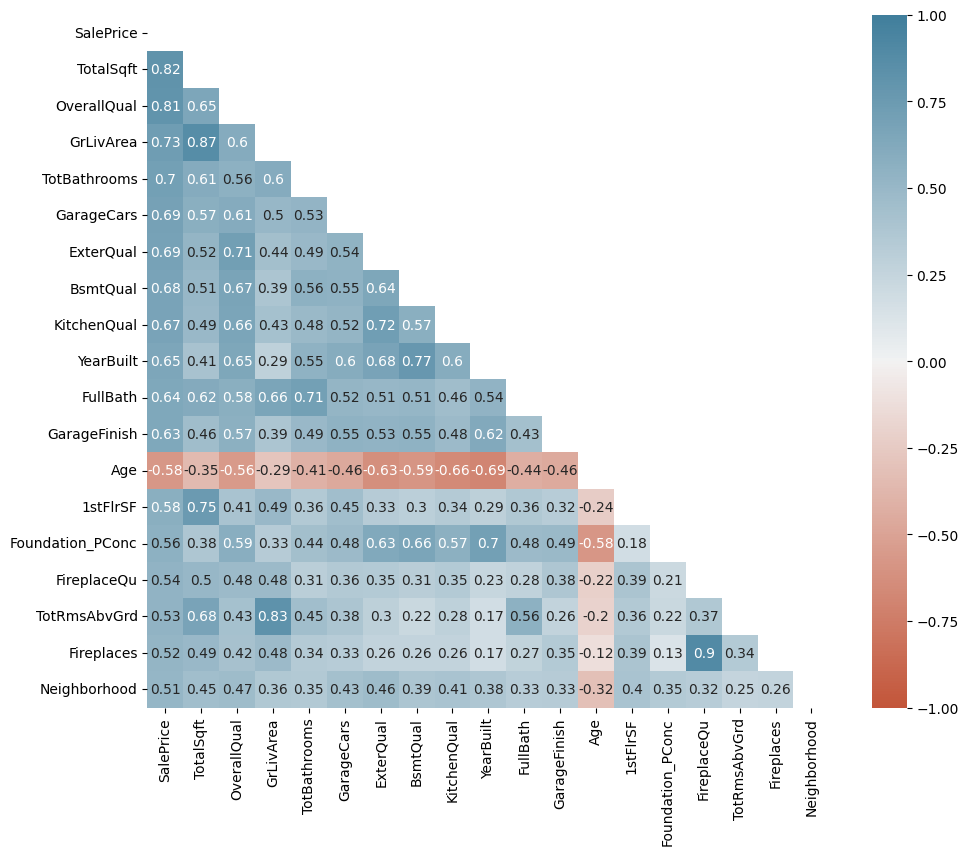

In [114]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")

plt.subplots(figsize=(11, 9))
sns.heatmap(high_corr,
    mask=np.triu(np.ones_like(high_corr, dtype=bool)),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    vmax=1, vmin=-1, center=0,
    annot=True,
)
None

In [115]:
output = pd.DataFrame(columns=["column1 (& type)", "column2 (& type)", "correlation"])

correlations = dict()
for col1, item in dict(both_corr).items():
    for col2, value in dict(item).items():
        if col1 == col2:
            continue
        key1, key2 = sorted([col1, col2])
        correlations[(key1, key2)] = value

correlations = sorted(correlations.items(), reverse=True, key=lambda x: abs(x[1]))
limit = 20
n = 0
for (key1, key2), value in correlations:
    if n >= limit:
        break
    if "categorical" in [column_types[key1], column_types[key2]]:
        continue
    output.loc[n] = [f"{key1} ({column_types[key1] or 'numeric'})", f"{key2} ({column_types[key2] or 'numeric'})", value]
    n += 1
output

,column1 (& type),column2 (& type),correlation
0,PoolArea (ordinal),PoolQC (ordinal),0.999993
1,FireplaceQu (ordinal),Fireplaces (numeric),0.903935
2,GrLivArea (ordinal),TotalSqft (ordinal),0.862384
3,SalePrice (numeric),TotalSqft (ordinal),0.816229
4,OverallQual (numeric),SalePrice (numeric),0.811082
5,GrLivArea (ordinal),TotRmsAbvGrd (numeric),0.808375
6,BsmtQual (ordinal),YearBuilt (numeric),0.786542
7,1stFlrSF (ordinal),TotalSqft (ordinal),0.751192
8,GrLivArea (ordinal),SalePrice (numeric),0.732342
9,ExterQual (ordinal),KitchenQual (ordinal),0.723452


In [116]:
drop_correlated_columns = [
    "MSSubClass_90", # correlates exactly with BldgType_Duplex
    "GarageArea", # correlates strongly with GarageCars (which correlates better with SalePrice)
    "TotRmsAbvGrd", # correlates strongly with GrLivArea (which correlates better with SalePrice)
    # "Age", # correlates strongly with GarageYrBlt (which correlates better with SalePrice)
]

# De-skew, center, and scale numeric columns

In [117]:
from sigfig import round
verbose = True
do_de_skew = set(["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF2", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtHalfBath", "KitchenAbvGr", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "TotalSqft", "PorchSqft"])
dont_de_skew = set(["YearBuilt", "BsmtFullBath", "FullBath", "HalfBath", "BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "TotBathrooms", "Age"])
all_numeric_from_erik = do_de_skew | dont_de_skew

new_de_skew = (do_de_skew - set(["BsmtFinSF2", "MasVnrArea"])) | set(["basement Unfinished sqft", "masonry other sqft", "masonry Brick Common sqft", "masonry Stone sqft", "basement Low Quality sqft", "basement Below Average Living Quarters sqft", "basement Average Rec Room sqft", 'masonry Brick Face sqft', 'basement Average Living Quarters sqft', 'basement Good Living Quarters sqft'])
all_newmeriks = new_de_skew | dont_de_skew

output = []
for col in transformed_data.columns:
    skew = transformed_data[col].skew()
    agreement = (abs(skew) > 0.8 and col in new_de_skew) or (abs(skew) <= 0.8 and col not in new_de_skew) or (column_types[col] in ["ordinal", "categorical"])
    output.append(dict(column=col, type=column_types[col] or "numeric", skew=skew, agree="👍" if agreement else "🙅‍♀️", seven=7))
output = sorted(output, key=lambda x: abs(x["skew"]), reverse=True)
output = pd.DataFrame(output)
indicies = set(output[output["type"] == "numeric"].index) | set(output[output["column"].isin(new_de_skew)].index) | set(output[output["column"].isin(dont_de_skew)].index)
output = output.iloc[sorted([i for i in indicies])].reset_index(drop=True)
with pd.option_context("display.max_rows", None):
    if verbose:
        display.display(output)
        print("missing columns from Erik", all_numeric_from_erik - set(transformed_data.columns))
        print("disagreement", set(output[output["agree"] == "🙅‍♀️"]["column"]))

def roundington(column_name="", data_set=None, decimals=14, **_):
    # fast but inaccurate
    # TODO: add extension to sigfig which greatly improves speed by generating result numerically instead of through string comprehension
    data_set[column_name] = data_set[column_name].round(decimals)
    return dict(data_set=data_set)

integate = [
    Transformation(column_name=col, function=NA_to_zero) for col in all_numeric_from_erik
] + [
    Transformation(column_name=col, function=re_map, args=[int]) for col in all_numeric_from_erik - {"TotBathrooms"}
]
de_skew = [Transformation(column_name=col, function=re_map, args=[log1p]) for col in do_de_skew]
round_em = [Transformation(column_name=col, function=re_map, args=[lambda x: round(x, 15)]) for col in do_de_skew]
# round_em = [Transformation(column_name=[col for col in do_de_skew], function=roundington)]
scale_em = [Transformation(column_name=col, function=scale) for col in all_numeric_from_erik]

numeriks = integate + de_skew + round_em + scale_em
newmeriks = [
    Transformation(column_name=col, function=NA_to_zero) for col in all_newmeriks
] + [
    Transformation(column_name=col, function=re_map, args=[log1p]) for col in new_de_skew
] + [
    Transformation(column_name=col, function=scale) for col in all_newmeriks
]
# numeriks = de_skew + round_em + scale_em

,column,type,skew,agree,seven
0,basement Unfinished sqft,ordinal,48.317709,👍,7
1,masonry other sqft,ordinal,26.969962,👍,7
2,PoolArea,ordinal,15.631314,👍,7
3,masonry Brick Common sqft,ordinal,11.079917,👍,7
4,3SsnPorch,ordinal,8.826656,👍,7
5,LowQualFinSF,ordinal,8.559041,👍,7
6,attraction proximity,numeric,8.080032,🙅‍♀️,7
7,rail proximity,numeric,5.473805,🙅‍♀️,7
8,MiscVal,ordinal,5.214687,👍,7
9,BsmtHalfBath,ordinal,3.775149,👍,7


missing columns from Erik {'MasVnrArea', 'BsmtFinSF2'}
disagreement {'attraction proximity', 'rail proximity', 'SalePrice', 'busy road proximity'}


# Find sparse data for dropping

In [126]:
transformed_data = transform_data(transformations=post_erik, data_set=full_data, pre_fit=True)["data_set"]

transformed_train_data = transformed_data[transformed_data["SalePrice"].notna()].drop("SalePrice", axis=1)
transformed_test_data = transformed_data[transformed_data["SalePrice"].isna()].drop("SalePrice", axis=1)
columns_with_same_val = set([col for col in transformed_data.drop("SalePrice", axis=1).columns if \
    len(transformed_train_data.index) - max(transformed_train_data[col].value_counts()) < 20 or \
    len(transformed_test_data.index) - max(transformed_test_data[col].value_counts()) < 20 \
])

output = pd.DataFrame(columns=["column", "type", "training occurrences", "test occurrences", "mode", "decision", "total"])
drop_saturated_columns = []
for i, col in enumerate(columns_with_same_val):
    non_similar_full = len(transformed_train_data.index) - max(transformed_train_data[col].value_counts())
    non_similar_test = len(transformed_test_data.index) - max(transformed_test_data[col].value_counts())
    # dr0p = non_similar_full == 0 or non_similar_test == 0 or non_similar_full + non_similar_test < 19 and column_types[col] == "categorical"
    dr0p = non_similar_full == 0 or non_similar_test == 0
    popular_value = transformed_train_data[col].value_counts().idxmax()
    output.loc[i+1] = [col, column_types[col], non_similar_full, non_similar_test, popular_value, "🔪" if dr0p else "👍", non_similar_full + non_similar_test]
    if dr0p:
        drop_saturated_columns.append(col)

with pd.option_context('display.max_rows', None):
    display.display(output.sort_values("total").reset_index(drop=True))

print(drop_saturated_columns)

,column,type,training occurrences,test occurrences,mode,decision,total
0,basement Unfinished sqft,numeric,1,1,0.0,👍,2
1,masonry other sqft,ordinal,3,1,0.0,👍,4
2,Exterior AsphShn,categorical,3,1,0.0,👍,4
3,Exterior CBlock,categorical,1,3,0.0,👍,4
4,Exterior BrkComm,categorical,2,4,0.0,👍,6
5,Exterior Stone,categorical,6,1,0.0,👍,7
6,Fence_MnWw,categorical,11,1,0.0,👍,12
7,Street,ordinal,6,6,1.0,👍,12
8,PoolQC,ordinal,6,6,0.0,👍,12
9,PoolArea,ordinal,6,6,0.0,👍,12


[]


In [63]:
pd.set_option('display.max_rows', 20)
drop_columns = list(set(drop_correlated_columns + drop_saturated_columns))
print(f"dropping the following {len(drop_columns)} columns:")
for col in drop_columns:
    print("  -", col)

transformation_schemes = [
    {
        "name": "Post-Erik (Lasso)",
        "transformations": post_erik + [
            Transformation(column_name="SalePrice", function=re_map, args=[lambda x: np.log(x)]),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
        "model": "Lasso",
        "leak_all_data": True,
    },
    {
        "name": "Post-Erik (XGB)",
        "transformations": post_erik + [
            Transformation(column_name="SalePrice", function=re_map, args=[lambda x: np.log(x)]),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
        "model": "xgb",
        "leak_all_data": True,
    },
    {
        "name": "Post-Erik XGB",
        "transformations": post_erik + [
            Transformation(column_name="SalePrice", function=re_map, args=[lambda x: np.log(x)]),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
        "model": "xgb",
        "leak_all_data": True,
    },
    {
        "name": "Erik Bruin's XGB",
        "transformations": erik_bruin + de_skew + scale_em + [
            Transformation(column_name="SalePrice", function=re_map, args=[lambda x: np.log(x)]),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
        "model": "xgb",
        "leak_all_data": True,
    },
    {
        "name": "Erik Bruin's Lasso",
        "transformations": erik_bruin + de_skew + scale_em + [
            Transformation(column_name="SalePrice", function=re_map, args=[lambda x: np.log(x)]),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
        "model": "Lasso",
        "leak_all_data": True,
    },
    {
        "name": "big drop +normalize+new",
        "transformations": new_transformations + shared_transformations + [
            Transformation(column_name="SalePrice", function=re_map, args=[log]),
            Transformation(column_name=drop_columns, function=drop, kwargs=dict(ignore_errors=True)),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
    },
] + transformation_schemes

dropping the following 3 columns:
  - TotRmsAbvGrd
  - MSSubClass_90
  - GarageArea


# Cross-validation

In [ ]:
from sklearn.metrics import root_mean_squared_error
from capture_output import Capturing
from random import shuffle

def generate_cross_validation_sets(data=train_data, sets=5):
    ids = data["Id"].to_list()
    shuffle(ids)
    set_size = len(data) // sets
    for n in range(sets):
        yield sorted(ids[n*set_size:(n+1)*set_size])

def split_and_transform_data(data=train_data, test_ids=None, transformations=[], leak_validation_data=False, leak_all_data=False, **_):
    if leak_all_data:
        data = transform_data(data_set=full_data, transformations=transformations, pre_fit=True)["data_set"]
        training_data = data.drop(data[data["Id"].isin(test_ids)].index)
        training_data = training_data[training_data["SalePrice"].notna()]
        training_price = training_data["SalePrice"]
        validation_data = data[data["Id"].isin(test_ids)]
        validation_price = validation_data["SalePrice"]
        return training_data, training_price, validation_data, validation_price
    if leak_validation_data:
        data = transform_data(data_set=train_data, transformations=transformations, pre_fit=True)["data_set"]
        training_data = data.drop(data[data["Id"].isin(test_ids)].index)
        training_price = training_data["SalePrice"]
        validation_data = data[data["Id"].isin(test_ids)]
        validation_price = validation_data["SalePrice"]
        return training_data, training_price, validation_data, validation_price
    
    training_data = data.drop(data[data["Id"].isin(test_ids)].index)
    results = transform_data(
        data_set=training_data,
        transformations=transformations,
        pre_fit=True,
        # TODO: indicate that the test set will be used for validation
    )
    training_data = results["data_set"]
    training_price = training_data["SalePrice"]

    validation_data = data[data["Id"].isin(test_ids)]
    validation_data = transform_data(
        data_set=validation_data,
        transformations=transformations,
        kwargs=results["kwargs"], 
        pre_fit=True,
    )["data_set"]
    validation_price = validation_data["SalePrice"]

    return training_data, training_price, validation_data, validation_price

from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor
def cross_validate(test_ids, scheme=None, xgb_params={"n_estimators":1_000, "learning_rate":0.05, "early_stopping_rounds":5}):
    training_data, training_price, validation_data, validation_price = split_and_transform_data(test_ids=test_ids, **scheme)

    missing_columns = (set(validation_data.columns) - set(training_data.columns) | set(training_data.columns) - set(validation_data.columns)) - set(["SalePrice", "Id"])
    if missing_columns:
        print("the following columns exist in only 1 data set", list(missing_columns))
    training_data.drop(list(missing_columns), axis=1, inplace=True, errors='ignore')
    validation_data.drop(list(missing_columns), axis=1, inplace=True, errors='ignore')

    model = None
    # model = XGBRegressor(**xgb_params)
    model = GradientBoostingRegressor(**xgb_params)
    with Capturing() as output:
        # model.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_price, eval_set=[(validation_data.drop(["SalePrice", "Id"], axis=1), validation_price)])
        model.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_price)

    predictions = model.predict(validation_data.drop(["SalePrice", "Id"], axis=1))
    predictions = transform_data(data_set=predictions, transformations=scheme["transformations"], post_fit=True)["data_set"]

    validation_price_original = train_data[train_data["Id"].isin(validation_data["Id"].to_list())]["SalePrice"]
    error = float(root_mean_squared_error(log1p(validation_price_original), log1p(predictions)))

    x = pd.DataFrame({"SalePrice": validation_price_original, "predictions": predictions})
    x["scheme"] = scheme["name"]
        
    return {"error": error, "iterations": len(output), "details": x}

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
def cross_validate_lasso(test_ids, scheme=None, model_params={"alpha":0.0}):
    training_data, training_price, validation_data, validation_price = split_and_transform_data(test_ids=test_ids, **scheme)

    missing_columns = (set(validation_data.columns) - set(training_data.columns) | set(training_data.columns) - set(validation_data.columns)) - set(["SalePrice", "Id"])
    if missing_columns:
        print("the following columns exist in only 1 data set", list(missing_columns))
    training_data.drop(list(missing_columns), axis=1, inplace=True, errors='ignore')
    validation_data.drop(list(missing_columns), axis=1, inplace=True, errors='ignore')

    lasso = None
    lasso = make_pipeline(
        RobustScaler(),
        LassoCV(
            max_iter=int(1e7),
            alphas=[3e-4, 3.5e-4, 4e-4, 4.5e-4, 5e-4], #, 0.000_156_165, 0.000_006
            random_state=92_384,
            cv=KFold(n_splits=13, shuffle=True, random_state=92_384),
    ))
    with Capturing() as output:
        lasso_model = lasso.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_price)

    predictions = lasso_model.predict(validation_data.drop(["SalePrice", "Id"], axis=1))
    predictions = transform_data(data_set=predictions, transformations=scheme["transformations"], post_fit=True)["data_set"]

    validation_price_original = train_data[train_data["Id"].isin(validation_data["Id"].to_list())]["SalePrice"]
    error = float(root_mean_squared_error(log1p(validation_price_original), log1p(predictions)))

    x = pd.DataFrame({"SalePrice": validation_price_original, "predictions": predictions})
    x["scheme"] = scheme["name"]
        
    return {"error": error, "iterations": len(output), "details": x}

# Find optimal XGB parameters

In [65]:
skip = True
fast = True # runtime is ~ 25 minutes when True
manually_define_optimal_params = True
desired_runtime = timedelta(hours=12)

from itertools import product

hpo_grid_options = {
    "n_estimators": [1_000],
    "learning_rate": [.1, .05, .01],
    "max_depth": [n for n in range(2, 7)],
    "gamma": [0],
    "colsample_bytree": [0.7, 1],
    "min_child_weight": [n for n in range(6)],
    "subsample": [1],
    "booster": ["gbtree"],
    "objective": ['reg:squarederror'],
    'random_state': [42],
    'seed': [27],
    'reg_alpha': [6e-05, 0.5],
}
erik_options =  {
    'n_estimators': 454,
    'learning_rate': 0.1,
    'max_depth': 2,
    'gamma': 0,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample': 1,
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'seed': 27,
    'reg_alpha': 6e-05,
}
new_best = {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 3, 'gamma': 0, 'colsample_bytree': 1, 'min_child_weight': 3, 'subsample': 1, 'booster': 'gbtree', 'objective': 'reg:linear'}
ensemble_params = {
    'n_estimators': 3_000,
    'learning_rate': 0.05,
    'max_depth': 4,
    'max_features': 'sqrt',
    'min_samples_leaf': 15,
    'min_samples_split': 10, 
    'loss': 'huber',
    'random_state': 42,
}
hpo_grid_options = {
    "n_estimators": [500, 1_000, 3_000],
    "learning_rate": [.1, .05, .01],
    "max_depth": [n for n in range(3, 6)],
    'max_features': ['sqrt'],
    'min_samples_leaf': [15],
    'min_samples_split': [10], 
    'loss': ['huber'],
    'random_state': [42, 420],
}

def hpo_grid(grid_options):
    keys = list(grid_options.keys())
    values = list(grid_options.values())
    for combination in product(*values):
        yield dict(zip(keys, combination))

scores = dict()
optimal_score = float("inf")
optimal_rounds = 1_000
optimal_xgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "max_depth": 3,
    "gamma": 0,
    "colsample_bytree": 1,
    "min_child_weight": 4,
    "subsample": 1,
    "booster": "gbtree",
    "objective": "reg:linear",
}

streak_limit = 20
options = np.prod([len(v) for v in hpo_grid_options.values()])
time_limit = desired_runtime / options
validation_sets = [s for s in generate_cross_validation_sets(sets=5)]
for n, params in enumerate(hpo_grid(hpo_grid_options)):
    if skip:
        break
    streak = {"value": 0, "length": 0}
    start_time = datetime.now()
    errors = []
    iterations = []
    while True:
        if streak["length"] > streak_limit:
            break
        time_elapsed = datetime.now() - start_time
        if time_elapsed > time_limit:
            break

        for test_ids in validation_sets if fast else generate_cross_validation_sets(sets=5):
            # xgb_params = params|{"early_stopping_rounds": 10}
            results = cross_validate(test_ids, scheme=transformation_schemes[0], xgb_params=params)
            errors.append(results["error"])
            iterations.append(results["iterations"])

        error = round(mean(errors), std(errors), sep=tuple, cutoff=99)
        scores[tuple(params.values())] = {
            "error": {"value": error[0], "+/-": error[1], "worst_case": max(errors), "worst_avg": error[0] + error[1], "measurements": errors},
            "iterations": {"value": mean(iterations), "+/-": std(iterations), "measurements": iterations},
        }
        if error[0] < optimal_score:
            optimal_score = error[0]
            optimal_xgb_params = params
            optimal_rounds = mean(iterations)        
        if fast:
            break

        if error == streak["value"]:
            streak["length"] += 1
        else:
            streak["value"] = error
            streak["length"] = 1

    display.clear_output(wait=True)
    print(f"iteration {n+1}/{options}.  Best result so far: {optimal_score:.5f} after {optimal_rounds} rounds with {optimal_xgb_params}")

import json
if not fast and not skip:
    json.dump({str(k): v for k, v in scores.items()}, open("hpo_scores.json", "w"))
else:
    scores = json.load(open('hpo_scores.json'))
    set_type = lambda x: float(x) if '.' in x else int(x)
    scores = {tuple(map(set_type, k[1:-1].split(", "))): v for k, v in scores.items()}

besties = set()

best_worst_error = sorted([(k, v['error']['worst_case']) for k, v in scores.items()], key=lambda x: x[1])[:3]
best_worst_error = defaultdict(lambda: "", zip([k for k, _ in best_worst_error], ("🥇", "🥈", "🥉")))
besties |= set([k for k in best_worst_error])
best_average_error = sorted([(k, v['error']['worst_avg']) for k, v in scores.items()], key=lambda x: x[1])[:3]
best_average_error = defaultdict(lambda: "", zip([k for k, _ in best_average_error], ("🥇", "🥈", "🥉")))
besties |= set([k for k in best_average_error])
min_error = min([round(mean(v['error']['measurements']), std(v['error']['measurements']), sep=tuple)[0] for v in scores.values()])
best_errors = [(k, round(mean(v['error']['measurements']), std(v['error']['measurements']), sep=tuple)) for k, v in scores.items() if round(mean(v['error']['measurements']), std(v['error']['measurements']), sep=tuple)[0] == min_error]
besties |= set([k for k, _ in best_errors])
besties = sorted([
    dict(zip(optimal_xgb_params.keys(), k)) |
    dict(zip(("error", "+/-"), round(mean(scores[k]['error']['measurements']), std(scores[k]['error']['measurements']), sep=tuple))) | {
    "worst_case": scores[k]['error']['worst_case'],
    "🥇": best_worst_error[k],
    "worst_avg": scores[k]['error']['worst_avg'],
    "🥈": best_average_error[k],
    "sorting": mean(scores[k]['error']['measurements']) + scores[k]['error']['worst_case'],
} for k in besties], key=lambda x: x['sorting'])

with pd.option_context('display.max_rows', None):
    display.display(pd.DataFrame(besties).drop('sorting', axis=1))

if manually_define_optimal_params:
    optimal_xgb_params = optimal_xgb_params = {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 3, 'gamma': 0, 'colsample_bytree': 0.7, 'min_child_weight': 0, 'subsample': 1, 'booster': 'gbtree', 'objective': 'reg:squarederror', 'random_state': 42, 'seed': 27, 'reg_alpha': 6e-05}
else:
    optimal_xgb_params = {k:v for k,v in besties[0].items() if k in optimal_xgb_params}

,n_estimators,learning_rate,max_depth,gamma,colsample_bytree,min_child_weight,subsample,error,+/-,worst_case,🥇,worst_avg,🥈
0,1000,0.05,3,0,1,5,1,0.120,0.009,0.142044,🥇,0.1299,
1,1000,0.10,2,0,1,4,1,0.120,0.009,0.142411,🥈,0.1296,
2,1000,0.10,2,0,1,5,1,0.120,0.009,0.143100,,0.1289,🥇
3,1000,0.05,2,0,1,5,1,0.120,0.010,0.145355,,0.1291,
4,1000,0.05,3,0,1,3,1,0.120,0.010,0.143981,,0.1310,
5,1000,0.01,3,0,1,3,1,0.122,0.009,0.143046,🥉,0.1309,
6,1000,0.10,2,0,1,2,1,0.120,0.010,0.146021,,0.1310,
7,1000,0.05,2,0,1,3,1,0.120,0.009,0.147040,,0.1293,
8,1000,0.10,4,0,1,2,1,0.120,0.010,0.144445,,0.1327,
9,1000,0.05,2,0,1,4,1,0.120,0.009,0.147449,,0.1291,🥉


# Find optimal Lasso parameter

In [66]:
fast = True
skip = True

scores = dict()
best = dict(
    score = float("inf"),
    alpha=None,
)
rounds = 100

streak_limit = 20
time_limit = timedelta(minutes=5)
validation_sets = [s for s in generate_cross_validation_sets(sets=5)]
for n, params in enumerate([{"alpha": a  / rounds} for a in range(rounds + 1)]):
    if skip:
        break
    streak = {"value": 0, "length": 0}
    start_time = datetime.now()
    errors = []
    # iterations = []
    while True:
        if streak["length"] > streak_limit:
            break
        time_elapsed = datetime.now() - start_time
        if time_elapsed > time_limit:
            break

        for test_ids in validation_sets if fast else generate_cross_validation_sets(sets=5):
            results = cross_validate_lasso(test_ids, scheme=transformation_schemes[0], model_params=params)
            errors.append(results["error"])
            # iterations.append(results["iterations"])

        error = round(mean(errors), std(errors), sep=tuple, cutoff=99)
        scores[tuple(params.values())] = {
            "error": {"value": error[0], "+/-": error[1], "worst_case": max(errors), "worst_avg": error[0] + error[1], "measurements": errors},
            # "iterations": {"value": mean(iterations), "+/-": std(iterations), "measurements": iterations},
        }
        if error[0] < best["score"]:
            best["score"] = error[0]
            best["alpha"] = params["alpha"]
            # optimal_rounds = mean(iterations)        
        if fast:
            break

        if error == streak["value"]:
            streak["length"] += 1
        else:
            streak["value"] = error
            streak["length"] = 1

    display.clear_output(wait=True)
    print(f"iteration {n+1}/{rounds}.  Best result so far: {best['score']:.5f} with alpha={best['alpha']}")

In [67]:
if not skip:
    df = pd.DataFrame([{"alpha": k[0], "error_avg": v["error"]["value"], "worst_case": v["error"]["worst_case"], "errors":v["error"]["measurements"]} for k,v in scores.items()]).explode('errors').melt(id_vars=["alpha"])
    sns.lineplot(df, x="alpha", y="value", hue="variable")
None

In [68]:
transformations = erik_bruin + numeriks + [
    Transformation(column_name="SalePrice", function=re_map, args=[log]),
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
]
td = transform_data(
    data_set=full_data,
    transformations=transformations,
    pre_fit=True,
)["data_set"]

/tmp/ipykernel_9454/1644262487.py:40: UserWarning: 15 significant figures requested from number with only 1 significant figures
  round_em = [Transformation(column_name=col, function=re_map, args=[lambda x: round(x, 15)]) for col in do_de_skew]
/tmp/ipykernel_9454/1644262487.py:40: UserWarning: 15 significant figures requested from number with only 14 significant figures
  round_em = [Transformation(column_name=col, function=re_map, args=[lambda x: round(x, 15)]) for col in do_de_skew]
/tmp/ipykernel_9454/1644262487.py:40: UserWarning: 15 significant figures requested from number with only 13 significant figures
  round_em = [Transformation(column_name=col, function=re_map, args=[lambda x: round(x, 15)]) for col in do_de_skew]


In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
model = None
model = Lasso()

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
search = GridSearchCV(model, {"alpha": np.arange(0, 1.01, 0.01)}, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)

train = td[td["SalePrice"].notna()]
results = search.fit(train.drop(["SalePrice", "Id"], axis=1), train["SalePrice"])
results.best_score_, results.best_params_

NameError: name 'Lasso' is not defined

# Fit, cross-validate, & compare transformation schemes

RMSE score using "Post-Erik (Lasso)" scheme: $ 0.1138 ± 0.0089 k
RMSE score using "Post-Erik (XGB)" scheme: $ 0.1206 ± 0.0096 k


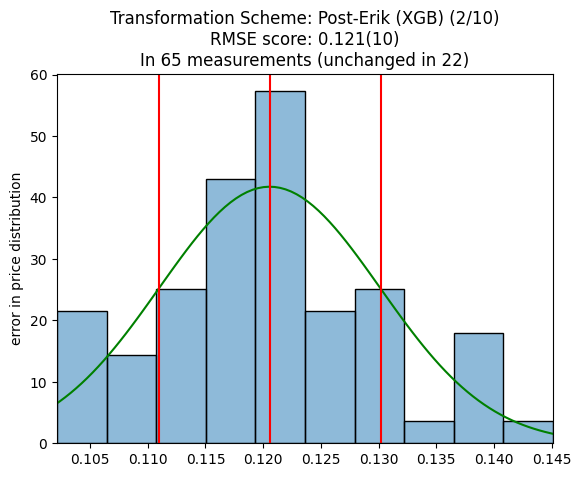

In [21]:
from numpy import linspace, log10, sqrt
from sigfig import round
from statistics import stdev as _stdev
from scipy.stats import norm, ks_1samp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

def stdev(data):
    try:
        return _stdev(data)
    except:
        return 0
def price_plot(errors=[], streak=0, label=""):
    base_plot = sns.histplot(pd.DataFrame(errors), legend=False, bins=10, stat='density')

    fit = norm
    x = linspace(*base_plot.get_xlim(), 100)
    y = fit.pdf(x, *fit.fit(errors))
    p = ks_1samp(errors, fit(*fit.fit(errors)).cdf).pvalue
    plt.plot(x, y, color="g", label=f"{fit.name} fit (p≈$10^{{{int(log10(p))}}}$)")

    plt.axvline(x = mean(errors), color = 'r')
    plt.axvline(x = mean(errors) + stdev(errors), color = 'r')
    plt.axvline(x = mean(errors) - stdev(errors), color = 'r')
    title = [
        f"Transformation Scheme: {label}" if label else "",
        f"RMSE score: {round(mean(errors), stdev(errors), format='Drake')}",
        f"In {len(errors)} measurements{f' (unchanged in {streak}' if streak else ''})",
    ]
    base_plot.set_title("\n".join([t for t in title if t]))
    base_plot.set_ylabel('error in price distribution')
    base_plot.set_xlim(min(errors), max(errors))
def update_price_plot(errors, label="", streak_length=None):
    try:
        plt.cla()
        price_plot(errors=errors, streak=streak_length, label=label)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except:
        None

def benchmark(scheme, time_limit=timedelta(minutes=15), streak_limit=20, verbose=True, validation_sets=5, label="", xgb=False):
    streak = {"value": 0, "length": 0}
    start_time = datetime.now()
    errors = []
    details = None
    while True:
        if streak["length"] > streak_limit:
            break
        time_elapsed = datetime.now() - start_time
        if time_elapsed > time_limit:
            break
        for test_ids in generate_cross_validation_sets(sets=validation_sets):
            if xgb:
                results = cross_validate(test_ids, scheme=scheme, xgb_params=optimal_xgb_params|{"early_stopping_rounds": 10})
            else:
                results = cross_validate_lasso(test_ids, scheme=scheme, model_params={"alpha": 0.0})
            errors.append(results["error"])
            if type(details) == type(None):
                details = results["details"]
            else:
                details = pd.concat([details, results["details"]])
            cumulative_error = round(mean(errors), stdev(errors), sep=tuple)
            if cumulative_error == streak["value"]:
                streak["length"] += 1
            else:
                streak["value"] = cumulative_error
                streak["length"] = 1

            if verbose:
                update_price_plot(errors, label=label, streak_length=streak["length"])

    return errors, details

results = []
details = None
for id, scheme in enumerate(transformation_schemes[:2]):
    label=f"{scheme['name']} ({id + 1}/{len(transformation_schemes)})"
    errors, new_details = benchmark(scheme, label=label, time_limit=timedelta(minutes=15), xgb = scheme["model"] == "xgb")
    if type(details) == type(None):
        details = new_details
    else:
        details = pd.concat([details, new_details])
    result = f"RMSE score using \"{scheme['name']}\" scheme: $ {round(mean(errors), stdev(errors), cutoff=99)} k"
    results.append(result)

for result in results:
    print(result)
details_copy = details.copy()

In [248]:
details = details_copy.copy()
details["RMSE (unscaled)"] = details.apply(lambda x: (log1p(x["SalePrice"]) - log1p(x["predictions"]))**2, axis=1)
details["% error"] = details.apply(lambda x: 100*(x["predictions"] - x["SalePrice"])/x["SalePrice"], axis=1)
details["|% error|"] = details["% error"].apply(abs)
scaler = max(details["|% error|"])/max(details['RMSE (unscaled)'])
details["RMSE"] = details.apply(lambda x: x["RMSE (unscaled)"]*scaler, axis=1)
details["Id"] = details.index

details = details.drop(["RMSE (unscaled)"], axis=1).melt(value_vars=["% error", "|% error|", "RMSE"], id_vars=["Id", "SalePrice", "scheme"], var_name="error type", value_name="error")
details

,Id,SalePrice,scheme,error type,error
0,14,157000,Post-Erik (Lasso),% error,-1.447997
1,15,132000,Post-Erik (Lasso),% error,0.984090
2,18,159000,Post-Erik (Lasso),% error,-3.505188
3,19,139000,Post-Erik (Lasso),% error,-12.758018
4,25,256300,Post-Erik (Lasso),% error,4.024270
...,...,...,...,...,...
153085,1439,197000,Post-Erik (XGB),RMSE,1.435260
153086,1449,92000,Post-Erik (XGB),RMSE,0.533865
153087,1450,136000,Post-Erik (XGB),RMSE,0.451501
153088,1452,145000,Post-Erik (XGB),RMSE,3.401887


/tmp/ipykernel_878/3162060397.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pe_details = details[details["error type"] == "% error"][details["scheme"] == "Post-Erik (Lasso)"]


This is clear as day, expensive houses are undervalued and cheap houses are overvalued.  This is more of a problem for lower priced houses since there are more of them and they're so far off in price.
A dirty hack solution would be to deflate the price of expensive houses and inflate the price of cheap houses... but I feel like a better SalesPrice scaler (ie. JohnsonSU) could fix this more elegantly.


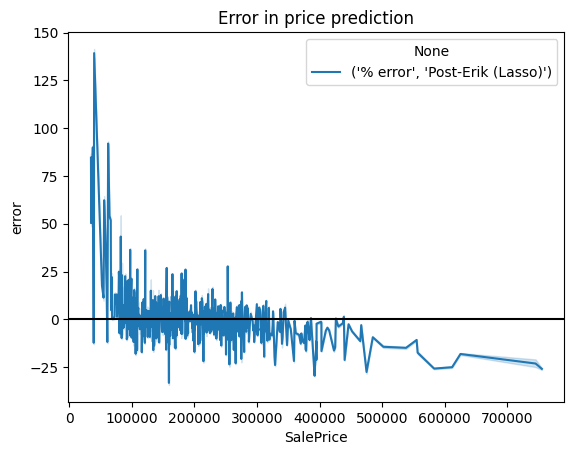

In [249]:
pe_details = details[details["error type"] == "% error"][details["scheme"] == "Post-Erik (Lasso)"]
sns.lineplot(pe_details, x="SalePrice", y="error", hue=pe_details[["error type", "scheme"]].apply(tuple, axis=1))
plt.title("Error in price prediction")
plt.axhline(y=0, color='k')
print("This is clear as day, expensive houses are undervalued and cheap houses are overvalued.  This is more of a problem for lower priced houses since there are more of them and they're so far off in price.")
print("A dirty hack solution would be to deflate the price of expensive houses and inflate the price of cheap houses... but I feel like a better SalesPrice scaler (ie. JohnsonSU) could fix this more elegantly.")

# Generate Output

In [129]:
train_transformations = post_erik + [
    Transformation(column_name="SalePrice", function=re_map, args=[log]),
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
]
test_transformations = post_erik + [
    Transformation(function=do_nothing), # because it must be the same length as train_transformations... plz fix
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
    # Transformation(function=manual_shift, pre_fit=False, post_fit=True),
    # Transformation(function=brutal_shift, pre_fit=False, post_fit=True),
    # Transformation(function=subtle_shift, pre_fit=False, post_fit=True),
]

leak_all_data = True
if not leak_all_data:
    results = transform_data(
        data_set=train_data,
        transformations=train_transformations,
        pre_fit=True,
    )
    training_data = results["data_set"]
    testing_data = transform_data(
        transformations=test_transformations,
        data_set=test_data,
        kwargs=results["kwargs"],
        pre_fit=True
    )["data_set"]
else:
    data = transform_data(
        data_set=full_data,
        transformations=train_transformations,
        pre_fit=True,
    )["data_set"]
    data.to_csv('mike_all.csv', index=False)
    
    training_data = data.drop(data[data["SalePrice"].isna()].index)
    testing_data = data[data["SalePrice"].isna()].drop("SalePrice", axis=1)

In [130]:
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor

# data = pd.read_csv("erik_all.csv")
data = pd.read_csv("mike_all.csv")

training_data = data.drop(data[data["SalePrice"].isna()].index)
testing_data = data[data["SalePrice"].isna()].drop("SalePrice", axis=1)

models = [
    XGBRegressor(**{'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 3, 'gamma': 0, 'colsample_bytree': 0.7, 'min_child_weight': 0, 'subsample': 1, 'booster': 'gbtree', 'objective': 'reg:squarederror', 'random_state': 42, 'seed': 27, 'reg_alpha': 6e-05}),
    make_pipeline(RobustScaler(), LassoCV(
        max_iter=int(1e7),
        alphas=[3e-4, 3.5e-4, 4e-4, 4.5e-4, 5e-4], #, 0.000_156_165, 0.000_006
        random_state=92_384,
        cv=KFold(n_splits=13, shuffle=True, random_state=92_384),
    )),
    make_pipeline(RobustScaler(), RidgeCV(
        alphas=[18.576_042_64, 18.576_042_65, 18.576_042_66],
        cv=KFold(
            n_splits=10,
            shuffle=True,
            random_state=42,
        ),
    )),
    make_pipeline(RobustScaler(), ElasticNetCV(
        max_iter=int(1e7),
        alphas=[0.000_212_24, 0.000_212_25, 0.000_212_26, 0.000_212_27, 0.000_212_28],
        random_state=42,
        l1_ratio=[0.991_4, 0.991_5, 0.991_6, 0.991_7, 0.991_8],
        cv=KFold(
            n_splits=9,
            shuffle=True,
            random_state=42,
    ))),
    make_pipeline(RobustScaler(), SVR(C=7, epsilon=0.017, gamma=0.0009)),
    LGBMRegressor(
        objective='regression',
        num_leaves=4,
        learning_rate=0.01,
        n_estimators=5_000,
        max_bin=200,
        bagging_fraction=0.75,
        bagging_freq=5,
        bagging_seed=7,
        feature_fraction=0.2,
        feature_fraction_seed=7,
        verbose=-1,
        min_data_in_leaf=2,
        min_sum_hessian_in_leaf=11,
    ),
    GradientBoostingRegressor(**{
        'n_estimators': 1_000,
        'learning_rate': 0.05,
        'max_depth': 3,
        'max_features': 'sqrt',
        'min_samples_leaf': 15,
        'min_samples_split': 10, 
        'loss': 'huber',
        'random_state': 42,
    }),
]
models = [
    StackingCVRegressor(
        regressors=models,
        meta_regressor=models[0],
        use_features_in_secondary=True,
    )
] + models

prediction_sets = []
for model in models:
    model = model.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_data["SalePrice"])
    predictions = model.predict(testing_data.drop("Id", axis=1))
    predictions = transform_data(transformations=test_transformations, data_set=predictions, post_fit=True, reference_data=testing_data)["data_set"]
    prediction_sets.append(predictions)

sale_price = ( sum(prediction_sets) + 2*prediction_sets[0] )/( len(prediction_sets) + 2 )
submission = pd.DataFrame({'Id': testing_data["Id"], 'SalePrice': sale_price})
submission.to_csv('submission.csv', index=False)
submission
#Takes ~30-40s with 6 stacked models

/home/mike/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


,Id,SalePrice
1458,1461,118747.851973
1459,1462,160511.502333
1460,1463,186523.657449
1461,1464,196183.746880
1462,1465,192825.928046
...,...,...
2912,2915,85239.836031
2913,2916,81462.444457
2914,2917,164261.827211
2915,2918,118068.367354


# Manual Data Validation

In [39]:
# manual validation
from itertools import chain
# load_data()
m_fields = [g for g in test_data.keys() if "masonry" in g] + ["Id"]
# for id, row in chain(test_data[garage_fields].iterrows(), full_data[garage_fields].iterrows()):
#     if row.isnull().any():
#         if any([type(i) == str for i in row]) or any([i > 0 if type(i) in [float, int] and key != "Id" else False for key, i in row.items()]):
#             print(row)
Idz = [1670, 2320, 2453, 2611, 625, 689, 774, 1231, 1242, 1301, 1335]
output = pd.DataFrame(columns=full_data.keys())
for s3t in test_data, full_data:
    output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])
output[m_fields]
# full_data.drop("Id", axis=1).isnull().values.any()
output = pd.DataFrame(columns=full_data.keys())
for id, row in test_data.iterrows():
    if row.isnull().any():
        output = pd.concat([output, test_data[test_data["Id"] == row["Id"]]])
# test_data.isnull().any(axis=1).sum()
output
column_types
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     #get ready to wait 75 seconds
#     display(full_data)
full_data[full_data["Id"].isin([813,939,826])]

/tmp/ipykernel_9454/77202551.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])
/tmp/ipykernel_9454/77202551.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, test_data[test_data["Id"] == row["Id"]]])


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
812,813,20,C (all),66.0,8712,Grvl,NaN,Reg,Bnk,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,5,5,1952,1952,Hip,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,Fa,TA,CBlock,TA,TA,Av,Unf,0.0,Unf,0.0,540.0,540.0,GasA,TA,N,FuseA,1044,0,0,1044,0.0,0.0,1,0,2,1,Fa,4,Typ,0,NaN,Basment,1952.0,Unf,2.0,504.0,TA,TA,N,0,0,0,0,0,0,NaN,NaN,Shed,54,6,2010,WD,Alloca,55993.0
825,826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,BrkFace,816.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1636.0,Unf,0.0,442.0,2078.0,GasA,Ex,Y,SBrkr,2084,0,0,2084,1.0,0.0,2,0,2,1,Ex,7,Typ,1,Gd,Attchd,2007.0,Fin,3.0,1220.0,TA,TA,Y,188,45,0,0,0,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000.0
938,939,60,RL,73.0,8760,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,Gd,Mn,GLQ,464.0,Unf,0.0,927.0,1391.0,GasA,Ex,Y,SBrkr,1391,571,0,1962,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2006.0,RFn,3.0,868.0,TA,TA,Y,0,90,0,0,0,0,NaN,NaN,NaN,0,8,2006,New,Partial,239799.0


In [123]:
td = transform_data(
    data_set=full_data,
    transformations=post_erik,
    pre_fit=True,
)["data_set"]
td[["busy road proximity", "rail proximity", "attraction proximity"]]
# td["%error"] = td.apply(lambda x: mean(super_bad[x["Id"]]) if x["Id"] in super_bad else 0, axis=1)

,busy road proximity,rail proximity,attraction proximity
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
2912,0,0,0
2913,0,0,0
2914,0,0,0
2915,0,0,0


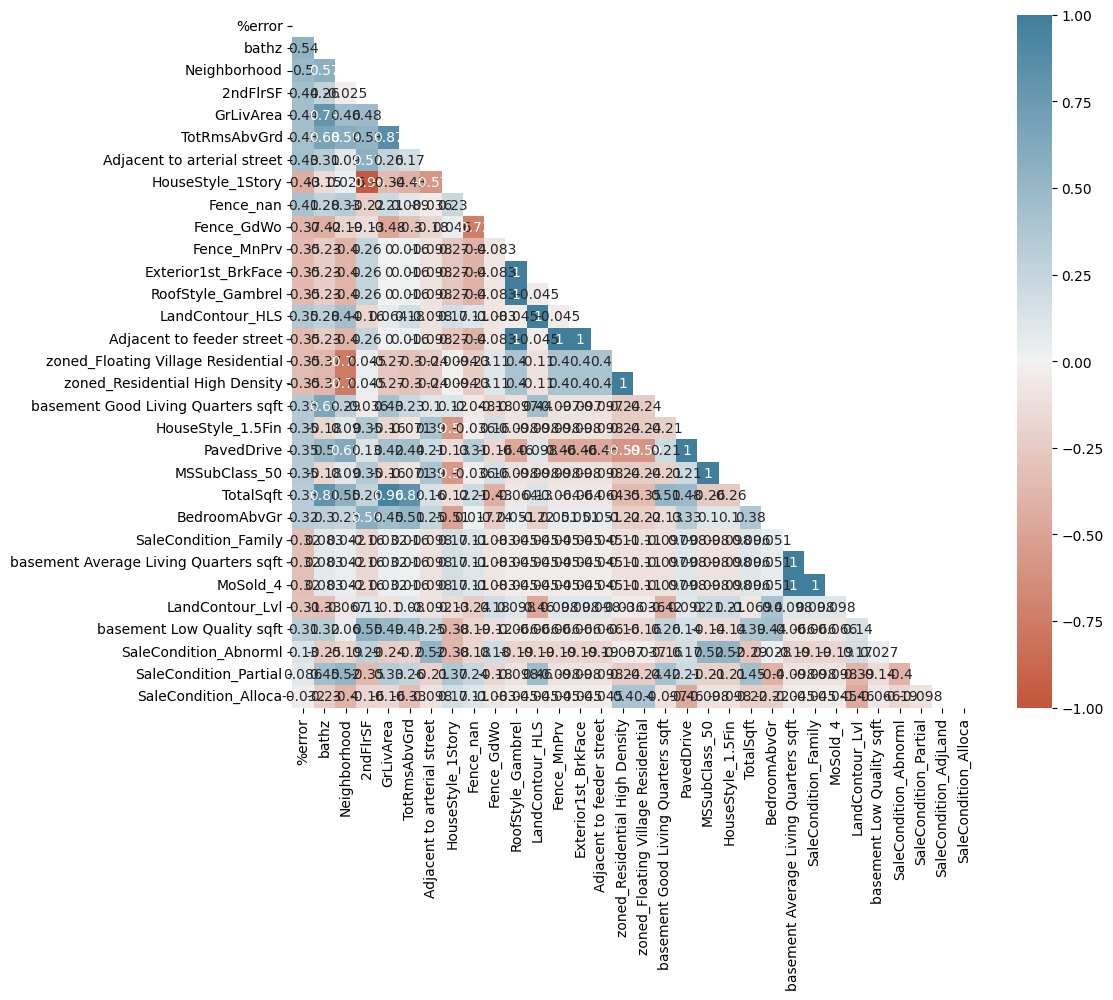

In [387]:
corr = None
corr = td[td["Id"].isin(set(baddoz["Id"]))].corr(method="spearman")
corr.dropna(axis=0, how="all", inplace=True)

both_corr = None
both_corr = td[td["Id"].isin(set(baddoz["Id"]))].copy()
both_corr = both_corr.corr(method="spearman")
both_corr.dropna(axis=0, how="all", inplace=True)

strange_conditions = [f"SaleCondition_{c}" for c in ("Abnorml", "Partial", "AdjLand", "Alloca")]
indicies = list(corr["%error"][corr["%error"].abs() > 0.3].sort_values(ascending=False, key=abs).index) + strange_conditions
high_corr = corr[indicies][corr.index.isin(indicies)].sort_values(ascending=False, key=abs, by="%error")

high_corr

plt.subplots(figsize=(11, 9))
sns.heatmap(high_corr,
    mask=np.triu(np.ones_like(high_corr, dtype=bool)),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    vmax=1, vmin=-1, center=0,
    annot=True,
)
None

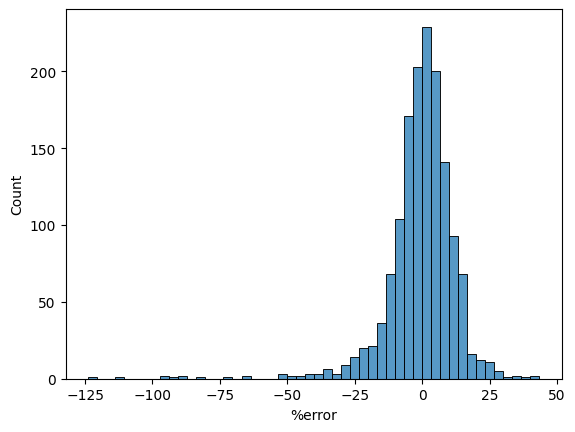

In [388]:
sns.histplot(td["%error"], legend=False, bins=50)
None

In [139]:
# generate pre-fit data to compare with Erik's

# transformations = erik_bruin + integate + de_skew + round_em + [
transformations = post_erik + [
    Transformation(column_name="SalePrice", function=re_map, args=[log]),
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
]
td = transform_data(
    data_set=full_data,
    transformations=transformations,
    pre_fit=True,
)["data_set"]

# td["LotFrontage"] = td["LotFrontage"].apply(lambda x: round(x, 15))

print(len(td[td["SalePrice"].notna()]), 'vs Eriks 1458 rows')
# td["TotBathrooms"].to_csv('TotBathrooms-me-unrounded.csv', index=False)
td[sorted(td.columns)][td["SalePrice"].notna()]
td[td['basement Unfinished sqft'] > 0][sorted(td.columns, key=lambda x: x.capitalize())]

1458 vs Eriks 1458 rows


,1stFlrSF,2ndFlrSF,3SsnPorch,Age,Alley_nan,Alley_Pave,attraction proximity,basement Average Living Quarters sqft,basement Average Rec Room sqft,basement Below Average Living Quarters sqft,basement Good Living Quarters sqft,basement Low Quality sqft,basement Unfinished sqft,BedroomAbvGr,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond,BsmtExposure,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,busy road proximity,CentralAir,Electrical_FuseF,Electrical_SBrkr,EnclosedPorch,ExterCond,Exterior AsphShn,Exterior Brk Cmn,Exterior BrkComm,Exterior BrkFace,Exterior CBlock,Exterior CemntBd,Exterior CmentBd,Exterior HdBoard,Exterior ImStucc,Exterior MetalSd,Exterior Plywood,Exterior Stone,Exterior Stucco,Exterior VinylSd,Exterior Wd Sdng,Exterior Wd Shng,Exterior WdShing,ExterQual,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,FireplaceQu,Fireplaces,Foundation_CBlock,Foundation_PConc,Foundation_Slab,FullBath,Functional,GarageCars,GarageFinish,GarageQual,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_nan,GrLivArea,HalfBath,Heating_GasA,Heating_GasW,HeatingQC,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Id,IsNew,KitchenAbvGr,KitchenQual,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope,LotArea,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,LotFrontage,LotShape,LowQualFinSF,masonry Brick Common sqft,masonry Brick Face sqft,masonry other sqft,masonry Stone sqft,MiscFeature_nan,MiscFeature_Shed,MiscVal,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_SWISU,Neighborhood_Timber,Neighborhood_Veenker,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,PorchSqft,rail proximity,Remodeled,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,SaleType_New,SaleType_WD,ScreenPorch,Street,TotalSqft,TotBathrooms,TotRmsAbvGrd,WoodDeckSF,YearBuilt,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
332,1629,0,0,5,1,0,0,0,0,0,1124,0,479,3,0,0,0,0,3,1,1.0,0.0,4,1603.0,0,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,1,4,1,0,1,0,2,7,3.0,2,3,1,0,0,0,0,1629,0,1,0,5,0,1,0,0,0,0,333,0,1,4,0,0,1,2,10655,0,0,1,85.0,2,0,0,296,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,8,2,0,0.0,0.0,0,1,1,0,1,0,0,0,0,1,0,12.55673,0,1,0,1,4835.0,3.0,7,0,2003,0,0,1,0
2282,1055,0,0,29,1,0,0,0,0,0,632,0,6,2,0,0,1,0,3,1,0.0,0.0,4,423.0,0,1,0,1,0,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,1,0,0,1,0,0,2,7,1.0,1,3,1,0,0,0,0,1055,0,1,0,3,0,1,0,0,0,0,2285,0,1,3,0,0,1,2,2304,0,0,1,24.0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,7,7,2,0,0.0,32.0,0,0,1,0,1,0,0,0,0,1,0,NaN,0,1,0,1,2116.0,2.0,4,108,1978,1,0,0,0


# Lasso parameter optimizing

In [372]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
def get_new_alphas(alpha, alphas):
    index = alphas.index(float(alpha))
    dif = (alpha - alphas[index - 1]) / 2
    output = sorted(set([max(alpha - dif, 0.0), alpha, min(alpha + dif, 1.0)]))
    return output
history2 = []
predictions = None
# for splits in [10, 11]:
splits = 13
# random_state = 92_384
# for splits in range(2, 21):
for random_state in [42, 420, 10, 92_384, 1_000, 10_000, 1_000_000, 27_042_018]:
    history = []
    alphas = [0.0, 0.5]
    alphas = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    for _ in range(20):
        lasso = make_pipeline(
            RobustScaler(),
            LassoCV(
                max_iter=int(1e7),
                alphas=alphas,
                random_state=random_state,
                cv=KFold(n_splits=splits, shuffle=True, random_state=random_state),
        ))
        model = lasso.fit(td[td["SalePrice"].notna()].drop(["SalePrice", "Id"], axis=1), td[td["SalePrice"].notna()]["SalePrice"])
        alphas = get_new_alphas(model[1].alpha_, alphas)
        history.append(model[1].alpha_)
    new_predictions = pd.DataFrame({"α": model[1].alpha_,"prediction": exp(model.predict(td[td["SalePrice"].isna()].drop(["SalePrice", "Id"], axis=1)))})
    new_predictions["Id"] = new_predictions.index + 1461
    if type(predictions) != type(None):
        predictions = pd.concat([predictions, new_predictions])
    else:
        predictions = new_predictions
    history2.append({"n_splits": splits, "random_state": random_state, "α":history[-1], "α (pretty)":round(history[-1], history[-1]-history[-2], format='Drake'), "step": history[-1]-history[-2]})
# display.display(pd.DataFrame(exp(model.predict(td[td["SalePrice"].isna()].drop(["SalePrice", "Id"], axis=1)))))
history2 = pd.DataFrame(history2)
sns.lineplot(history2, y="α", x="random_state")
plt.title("how α varies with the number of random state")
# sns.lineplot(history2, y="α", x="n_splits")
# plt.title("how α varies with the # of splits")
display.display(history2)

KeyboardInterrupt: 

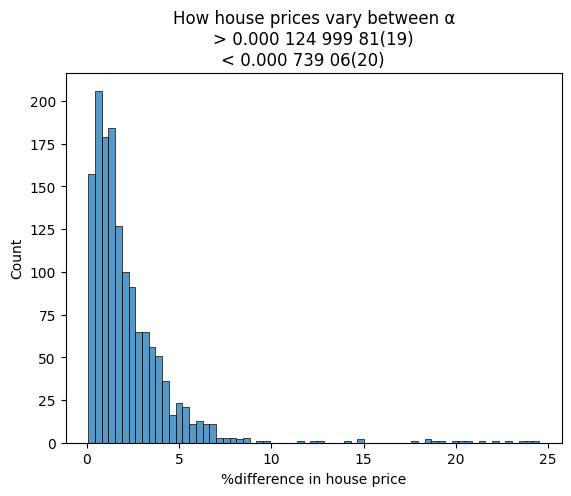

In [304]:
predictions.copy()
data = pd.DataFrame({"Id": predictions["Id"].unique()})
def percent_diff(row):
    predz = predictions[predictions["Id"] == row["Id"]]["prediction"]
    prediction_range = max(predz) - min(predz)
    return 100 * prediction_range / mean(predz)
data["%difference in house price"] = data.apply(percent_diff, axis=1)
# sns.lineplot(data, x="Id", y="%difference")
# plt.title("Percent difference in price")
sns.histplot(data["%difference in house price"])
limits = [
    history2[history2["α"] == min(history2["α"])]["α (pretty)"].iloc[0],
    history2[history2["α"] == max(history2["α"])]["α (pretty)"].iloc[0],
]
max_len=max([len(l) for l in limits])
plt.title(f"How house prices vary between α\n> {limits[0].ljust(max_len)}\n< {limits[1].ljust(max_len)}")
None

# XGB Parameter Optimizing

In [327]:
# attempt to find the parameters that best match Erik's XGB results

from xgboost import XGBRegressor

transformations = erik_bruin + numeriks + [
    Transformation(column_name="SalePrice", function=re_map, args=[log]),
    Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
]

data = transform_data(
    data_set=full_data,
    transformations=transformations,
    pre_fit=True,
)["data_set"]
training_data = data.drop(data[data["SalePrice"].isna()].index)
testing_data = data[data["SalePrice"].isna()].drop("SalePrice", axis=1)

/home/mike/kaggle/.venv/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 15 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 15 significant figures requested from number with only 14 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))
/home/mike/kaggle/.venv/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 15 significant figures requested from number with only 13 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


In [68]:
from itertools import product
skip = True
hpo_base ={
 'n_estimators': 454,
 'learning_rate': 0.1,
 'max_depth': 2,
 'gamma': 0,
 'colsample_bytree': 0.7,
 'min_child_weight': 0,
 'subsample': 1,
 'booster': 'gbtree',
 'objective': 'reg:squarederror',
 'random_state': 42,
 'seed': 27,
 'reg_alpha': 0.5,
}
hpo_grid_options = {
    "n_estimators": [454, 1_000, 2_000, 3_460],
    "learning_rate": [.1, .05, .01],
    "max_depth": [n for n in range(2, 5)],
    "gamma": [0],
    "colsample_bytree": [1, 0.7],
    "min_child_weight": [n for n in range(5)],
    "subsample": [1],
    "booster": ["gbtree"],
    "objective": ["reg:squarederror"],
    "random_state": [42, 420, 10, 92384, 1_000, 10_000, 1_000_000, 27_042_018],
    "seed": [27, 420, 10, 92384, 1_000, 10_000, 1_000_000, 27_042_018],
    "reg_alpha": [0.0, 0.5, .00006],
}

def hpo_grid(grid_options):
    keys = list(grid_options.keys())
    values = list(grid_options.values())
    for combination in product(*values):
        yield dict(zip(keys, combination))

def generate_predictions(params, training_data, testing_data, test_transformations):
    xgb_model = None
    xgb_model = XGBRegressor(**params)
    xgb_model.fit(training_data.drop(["SalePrice", "Id"], axis=1), training_data["SalePrice"])

    xgb_predictions = xgb_model.predict(testing_data.drop("Id", axis=1))
    xgb_predictions = transform_data(transformations=test_transformations, data_set=xgb_predictions, post_fit=True, reference_data=testing_data)["data_set"]
    
    return pd.DataFrame({"Id": testing_data["Id"], "SalePrice": xgb_predictions, **params})

if skip:
    results = generate_predictions(hpo_base, training_data, testing_data, test_transformations)
    options = np.sum([len(v) for v in hpo_grid_options.values()]) - len(hpo_grid_options)
    n = 1
    for key in hpo_grid_options:
        for val in set(hpo_grid_options[key]) - set([hpo_base[key]]):
            n += 1
            print(f"iteration {n}/{options}")
            result = generate_predictions(hpo_base|{key: val}, training_data, testing_data, test_transformations)
            results = pd.concat([results, result])
else:
    results = pd.DataFrame()
    options = np.prod([len(v) for v in hpo_grid_options.values()])
    for n, params in enumerate(hpo_grid(hpo_grid_options)):
        if not n % 50:
            print(f"iteration {n+1}/{options}")
        result = generate_predictions(params, training_data, testing_data, test_transformations)
        results = pd.concat([results, result])
results.to_csv('mikes-raw-xgb-tuning-results.csv', index=False)


iteration 2/40
iteration 3/40
iteration 4/40
iteration 5/40
iteration 6/40
iteration 7/40
iteration 8/40
iteration 9/40
iteration 10/40
iteration 11/40
iteration 12/40
iteration 13/40
iteration 14/40
iteration 15/40
iteration 16/40
iteration 17/40
iteration 18/40
iteration 19/40
iteration 20/40
iteration 21/40
iteration 22/40
iteration 23/40
iteration 24/40
iteration 25/40
iteration 26/40
iteration 27/40
iteration 28/40
iteration 29/40


In [69]:
erik_xgb = pd.read_csv("eriks-xgb-predictions.csv")
results = pd.read_csv("mikes-raw-xgb-tuning-results.csv")

scores = []
# for n, params in enumerate(hpo_grid(hpo_grid_options)):
param_options = [k for k in hpo_grid_options]
for id, params in results[param_options].drop_duplicates(param_options).iterrows():
    r = results.copy()

    for key, value, in params.items():
        r = r[r[key] == value]
        print(len(r))

    # try:
    score = root_mean_squared_error(log1p(erik_xgb["x"]), log1p(r["SalePrice"]))
    scores.append({"score": score, **params})
    # except:
    #     break

display.display(pd.DataFrame(sorted(scores, key=lambda x: x["score"])))

# 1,795,036 results took 6min 17s

37934
35016
32098
32098
30639
24803
24803
24803
24803
14590
4377
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
37934
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
37934
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
37934
35016
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
37934
35016
1459
1459
1459
1459
1459
1459
1459
1459
1459
1459
37934
35016
32098
32098
1459
1459
1459
1459
1459
1459
1459
1459
37934
35016
32098
32098
30639
1459
1459
1459
1459
1459
1459
1459
37934
35016
32098
32098
30639
1459
1459
1459
1459
1459
1459
1459
37934
35016
32098
32098
30639
1459
1459
1459
1459
1459
1459
1459
37934
35016
32098
32098
30639
1459
1459
1459
1459
1459
1459
1459
37934
35016
32098
32098
30639
24803
24803
24803
24803
1459
1459
1459
37934
35016
32098
32098
30639
24803
24803
24803
24803
1459
1459
1459
37934
35016
32098
32098
30639
24803
24803


,score,n_estimators,learning_rate,max_depth,gamma,colsample_bytree,min_child_weight,subsample,booster,objective,random_state,seed,reg_alpha
0,0.035461,454,0.10,2,0,0.7,0,1,gbtree,reg:squarederror,42,27,0.00006
1,0.035462,454,0.10,2,0,0.7,0,1,gbtree,reg:squarederror,42,27,0.00000
2,0.035554,454,0.10,2,0,0.7,2,1,gbtree,reg:squarederror,42,27,0.50000
3,0.035848,454,0.10,2,0,0.7,4,1,gbtree,reg:squarederror,42,27,0.50000
4,0.035894,454,0.05,2,0,0.7,0,1,gbtree,reg:squarederror,42,27,0.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,0.042094,3460,0.10,2,0,0.7,0,1,gbtree,reg:squarederror,42,27,0.50000
25,0.042094,2000,0.10,2,0,0.7,0,1,gbtree,reg:squarederror,42,27,0.50000
26,0.043036,454,0.10,3,0,0.7,0,1,gbtree,reg:squarederror,42,27,0.50000
27,0.047893,454,0.10,4,0,0.7,0,1,gbtree,reg:squarederror,42,27,0.50000


In [70]:
print(len(results))
sorted(scores, key=lambda x: x["score"])[0]

42311


{'score': np.float64(0.03546122155611154),
 'n_estimators': 454,
 'learning_rate': 0.1,
 'max_depth': 2,
 'gamma': 0,
 'colsample_bytree': 0.7,
 'min_child_weight': 0,
 'subsample': 1,
 'booster': 'gbtree',
 'objective': 'reg:squarederror',
 'random_state': 42,
 'seed': 27,
 'reg_alpha': 6e-05}

# Analysis of Predictable Error as a function of Prediction Price

/tmp/ipykernel_878/3755727216.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pe_details = details[details["error type"] == "% error"][details["scheme"] == "Post-Erik (Lasso)"]


hi fit line:             2
-1.056e-11 x - 4.197e-05 x + 10.36
low fit line:            6             5             4             3            2
8.253e-31 x - 1.428e-24 x + 9.773e-19 x - 3.391e-13 x + 6.26e-08 x - 0.005805 x + 211.2


/tmp/ipykernel_878/3755727216.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


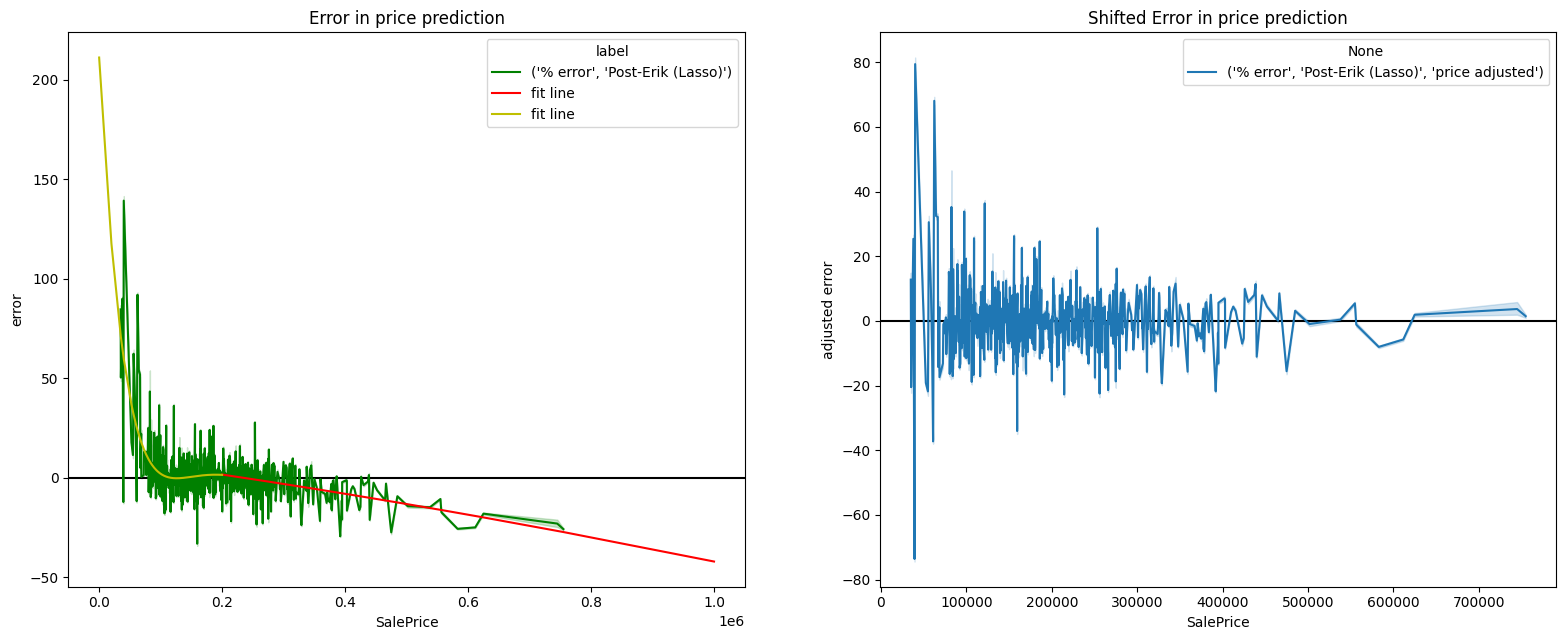

In [267]:
pe_details = details[details["error type"] == "% error"][details["scheme"] == "Post-Erik (Lasso)"]

model_low = np.poly1d(np.polyfit(pe_details[pe_details["SalePrice"] < 400_000]["SalePrice"], pe_details[pe_details["SalePrice"] < 400_000]["error"], 6))
model_hi = np.poly1d(np.polyfit(pe_details[pe_details["SalePrice"] >= 200_000]["SalePrice"], pe_details[pe_details["SalePrice"] >= 200_000]["error"], 2))
x_hi = np.concatenate(([200_000], pe_details[pe_details["SalePrice"] >= 200_000]["SalePrice"].unique(), [1_000_000]))
x_low = np.concatenate(([0], pe_details[pe_details["SalePrice"] < 200_000]["SalePrice"].unique(), [20_000]))
fit_line_low = pd.DataFrame({"SalePrice": x_low, "error": model_low(x_low), "label": "fit line"})
fit_line_hi = pd.DataFrame({"SalePrice": x_hi, "error": model_hi(x_hi), "label": "fit line"})
# pe_details["Adjusted SalePrice"] = pe_details["SalePrice"].apply(lambda x: x*(model_low(x)+100)/100 if x < 200_000 else x*(model_hi(x)+100)/100)
pe_details["adjusted error"] = pe_details.apply(lambda x: x["error"] - (model_low(x["SalePrice"]) if x["SalePrice"] < 200_000 else model_hi(x["SalePrice"])), axis=1)
pe_details["price adjusted"] = 'price adjusted'

# display.display(pe_details)
original_size = plt.rcParams['figure.figsize'].copy()
plt.rcParams['figure.figsize'] = [3*original_size[0], 1.5*original_size[1]]
fig, ax =plt.subplots(1,2)
ax[0].set_title("Error in price prediction")
ax[0].axhline(y=0, color='k')
sns.lineplot(pe_details, x="SalePrice", y="error", hue=pe_details[["error type", "scheme"]].apply(tuple, axis=1), palette=['g'], ax=ax[0])
sns.lineplot(fit_line_hi, x="SalePrice", y="error", palette=['r'], hue='label', ax=ax[0])
sns.lineplot(fit_line_low, x="SalePrice", y="error", palette=['y'], hue='label', ax=ax[0])

ax[1].set_title("Shifted Error in price prediction")
ax[1].axhline(y=0, color='k')
sns.lineplot(pe_details, x="SalePrice", y="adjusted error", hue=pe_details[["error type", "scheme", "price adjusted"]].apply(tuple, axis=1), ax=ax[1])
print("hi fit line:", model_hi)
print("low fit line:", model_low)

fig.show()
plt.rcParams['figure.figsize'] = original_size

In [44]:
details = details_copy.copy()
details["total error"] = details.apply(lambda x: x["predictions"] - x["SalePrice"], axis=1)
details["% error"] = details.apply(lambda x: 100*(x["predictions"] - x["SalePrice"])/x["SalePrice"], axis=1)
details["Id"] = details.index

details_xgb = details[details["scheme"] == "Post-Erik (XGB)"]
details_lasso = details[details["scheme"] == "Post-Erik (Lasso)"]

In [86]:
scoreboard = []
for fit_degree in range(1, 10):
    for error_type in ["total error", "% error"]:
        for model_name, data in [["xgb", details_xgb], ["lasso", details_lasso]]:
            for range_label, range_condition in [["hi", data["SalePrice"] >= 200_000], ["low", data["SalePrice"] < 200_000]]:
                model = np.poly1d(np.polyfit(data[range_condition]["SalePrice"], data[range_condition][error_type], fit_degree))
                if error_type == "total error":
                    model_adjusted_price = data[range_condition]["predictions"].apply(lambda x: x - model(x))
                else:
                    model_adjusted_price = data[range_condition]["predictions"].apply(lambda x: x*(100 - model(x))/100)

                # if range_label == "hi":
                #     x_hi = np.concatenate(([200_000], data[range_condition]["SalePrice"].unique(), [1_000_000]))
                #     fit_line_low_xgb = pd.DataFrame({"SalePrice": x_hi, "error": model(x_hi), "label": "fit line XGB"})
                #     sns.lineplot(fit_line_low_xgb, x="SalePrice", y="error", palette=['r'], hue='label')
                # display.display(model(data[range_condition]["predictions"]))
                try:
                    error = root_mean_squared_error(log1p(data[range_condition]["SalePrice"]), log1p(model_adjusted_price))
                except:
                    continue
                scoreboard.append({"degree": fit_degree, "error type": error_type, "model": model_name, "range": range_label, "score": error})

/home/mike/kaggle/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mike/kaggle/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mike/kaggle/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [87]:
print("Note: don't just take the best results as this can lead to brutal overfitting")
data = pd.DataFrame(sorted(scoreboard, key=lambda x: x["score"]))
for model_name in ["xgb", "lasso"]:
    for range_label in ["hi", "low"]:
        display.display(data[data["model"] == model_name][data["range"] == range_label].head())

/tmp/ipykernel_878/203676787.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display.display(data[data["model"] == model_name][data["range"] == range_label].head())


,degree,error type,model,range,score
15,9,% error,xgb,hi,0.107282
16,2,total error,xgb,hi,0.109497
17,4,total error,xgb,hi,0.110006
18,5,total error,xgb,hi,0.110884
19,4,% error,xgb,hi,0.111241


/tmp/ipykernel_878/203676787.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display.display(data[data["model"] == model_name][data["range"] == range_label].head())


,degree,error type,model,range,score
38,1,total error,xgb,low,0.129592
40,4,total error,xgb,low,0.131240
41,2,total error,xgb,low,0.131476
42,3,total error,xgb,low,0.132851
43,2,% error,xgb,low,0.133913


/tmp/ipykernel_878/203676787.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display.display(data[data["model"] == model_name][data["range"] == range_label].head())


,degree,error type,model,range,score
0,9,% error,lasso,hi,0.097603
1,5,total error,lasso,hi,0.097819
2,9,total error,lasso,hi,0.098231
3,5,% error,lasso,hi,0.099397
4,6,total error,lasso,hi,0.099827


/tmp/ipykernel_878/203676787.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display.display(data[data["model"] == model_name][data["range"] == range_label].head())


,degree,error type,model,range,score
31,1,total error,lasso,low,0.121316
33,2,% error,lasso,low,0.123200
34,2,total error,lasso,low,0.127130
36,4,% error,lasso,low,0.128573
37,1,% error,lasso,low,0.128859


xgb low fit parameters: [np.float64(-4.141724664362654e-29), np.float64(2.2962397540806572e-23), np.float64(-3.7977909705875635e-18), np.float64(-6.603445748216636e-14), np.float64(8.450148821218001e-08), np.float64(-0.008922203898227298), np.float64(309.8407641065316)]
xgb hi fit parameters: [np.float64(-8.148337734339915e-11), np.float64(2.7216602570671252e-05), np.float64(-3.3896822695718476)]
lasso hi fit parameters: [np.float64(6.220199605609797e-13), np.float64(-1.3058265774546924e-06), np.float64(0.4288294434539323), np.float64(-36621.40200299893)]


/tmp/ipykernel_878/1695478728.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  t["% error"] = t.apply(lambda x: -100*(1 - x["total error"] / x["SalePrice"])+100, axis=1)
/tmp/ipykernel_878/1695478728.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


lasso low fit parameters: [np.float64(-1.2041741724260382e-11), np.float64(6.759994393304108e-06), np.float64(-1.156529734485036), np.float64(62285.79973228294)]


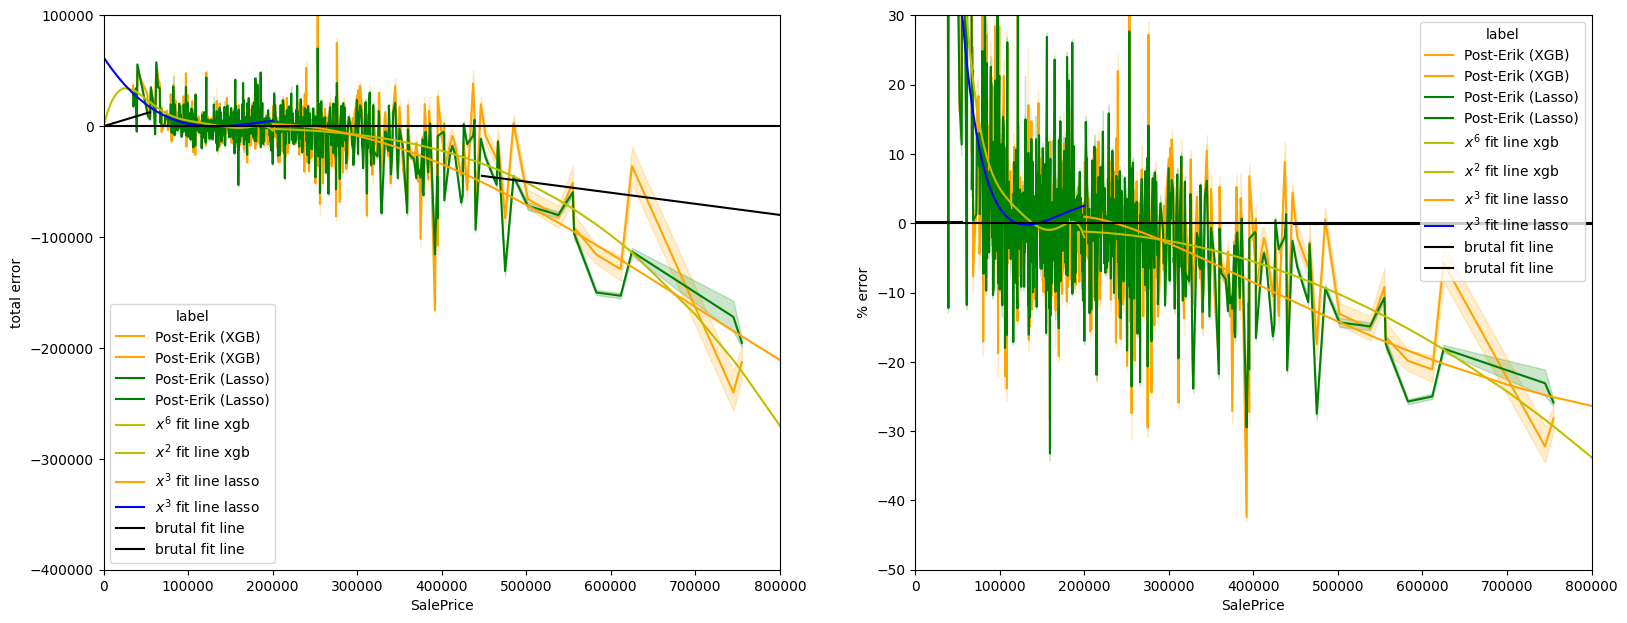

In [353]:
x = {
    "low": np.concatenate(([0, 1_000, 5_000, 10_000, 15_000, 20_000, 25_000], details[details["SalePrice"] < 200_000]["SalePrice"].unique(), [200_000])),
    "hi": np.concatenate(([200_000], details[details["SalePrice"] >= 200_000]["SalePrice"].unique(), [x * 100_000 for x in range(6, 11)])),
}

plt.rcParams['figure.figsize'] = [6.4, 4.8]
original_size = plt.rcParams['figure.figsize'].copy()
plt.rcParams['figure.figsize'] = [3*original_size[0], 1.5*original_size[1]]
fig, ax =plt.subplots(1,2)

for data, range_label, color in [
    (details_xgb, "low", "orange"),
    (details_xgb, "hi", "orange"),
    (details_lasso, "low", "green"),
    (details_lasso, "hi", "green"),
]:
    range_condition = {
        "low": data["SalePrice"] < 200_000,
        "hi": data["SalePrice"] >= 200_000,
    }[range_label]
    sns.lineplot(data[range_condition], x="SalePrice", y="total error", hue="scheme", palette=[color], ax=ax[0])
    sns.lineplot(data[range_condition], x="SalePrice", y="% error", hue="scheme", palette=[color], ax=ax[1])

for model_name, data,    range_label, error_type,   fit_degree, color, start_fit in [
    # ("xgb", details_xgb, "hi",       "total error", 2,          "r", 200_000),

    # ("xgb", details_xgb, "low",      "total error", 1,          "r", 200_000),
    # ("xgb", details_xgb, "low",      "total error", 4,          "b", 400_000),
    # ("xgb", details_xgb, "low",      "total error", 4,          "g", 200_000),
    ("xgb", details_xgb, "low",      "% error",     6,          "y", 200_000),
    # ("xgb", details_xgb, "hi",        "total error",     2,     "r", 200_000),

    ("xgb", details_xgb, "hi",      "% error",     2,          "y", 200_000),

    # ("lasso", details_lasso, "hi",      "total error",     4,          "r", 200_000),
    # ("lasso", details_lasso, "hi",      "total error",     2,          "b", 200_000),
    ("lasso", details_lasso, "hi",      "total error",     3,          "orange", 200_000),
    # ("lasso", details_lasso, "low",        "total error",     4,     "r", 200_000),
    ("lasso", details_lasso, "low",        "total error",     3,     "b", 200_000),
    # ("lasso", details_lasso, "low",        "total error",     2,     "orange", 200_000),
    # ("lasso", details_lasso, "low",        "total error",     1,     "k", 200_000),
]:
    range_condition = {
        "low": data["SalePrice"] < 200_000,
        "hi": data["SalePrice"] >= 200_000,
    }[range_label]
    fit_range = {
        "low": data["SalePrice"] < start_fit,
        "hi": data["SalePrice"] >= start_fit,
    }[range_label]
    model = np.poly1d(np.polyfit(data[fit_range]["SalePrice"], data[fit_range][error_type], fit_degree))
    if error_type == "total error":
        model_adjusted_price = data[range_condition]["predictions"].apply(lambda x: x - model(x))
        total_error = model(x[range_label])
        t = pd.DataFrame({"SalePrice": x[range_label], "total error": model(x[range_label]) })
        t["% error"] = t.apply(lambda x: -100*(1 - x["total error"] / x["SalePrice"])+100, axis=1)
        percent_error = t["% error"]
    else:
        model_adjusted_price = data[range_condition]["predictions"].apply(lambda x: x*(100 - model(x))/100)
        t = pd.DataFrame({"SalePrice": x[range_label], "% error": model(x[range_label]) })
        t["total error"] = t.apply(lambda o: o["SalePrice"] - o["SalePrice"]*(100 - o["% error"])/100, axis=1)
        # display.display(t)
        total_error = t["total error"]
        percent_error = t["% error"]
        # print(error)
        # print(pd.DataFrame({"SalePrice": x[range_label], "% error": model(x[range_label])}).apply(lambda x: x["SalePrice"]*(100 - x["% error"])/100))

    fit_line = pd.DataFrame({"SalePrice": x[range_label], "error": total_error, "label": f"$x^{{{fit_degree}}}$ fit line {model_name}"})
    sns.lineplot(fit_line, x="SalePrice", y="error", palette=[color], hue='label', ax=ax[0])
    fit_line = pd.DataFrame({"SalePrice": x[range_label], "error": percent_error, "label": f"$x^{{{fit_degree}}}$ fit line {model_name}"})
    sns.lineplot(fit_line, x="SalePrice", y="error", palette=[color], hue='label', ax=ax[1])
    print(model_name, range_label, "fit parameters:", list(model))

# brutal line
x_brutal = {
    "low": np.concatenate(([0], [54_891.35])),
    "hi": np.concatenate(([447_553.79], [1_000_000])),    
}
sns.lineplot(pd.DataFrame({"x": x_brutal["low"], "y": x_brutal["low"]*0.23, "label": "brutal fit line"}), x="x", y="y", palette=["k"], hue="label", ax=ax[0])
sns.lineplot(pd.DataFrame({"x": x_brutal["hi"], "y": -x_brutal["hi"]*0.1, "label": "brutal fit line"}), x="x", y="y", palette=["k"], hue="label", ax=ax[0])
sns.lineplot(pd.DataFrame({"x": x_brutal["low"], "y": 0.23, "label": "brutal fit line"}), x="x", y="y", palette=["k"], hue="label", ax=ax[1])
sns.lineplot(pd.DataFrame({"x": x_brutal["hi"], "y": -0.1, "label": "brutal fit line"}), x="x", y="y", palette=["k"], hue="label", ax=ax[1])

ax[0].axhline(y=0, color='k')
ax[1].axhline(y=0, color='k')
# set x limits to 0 and 1_000_000
ax[0].set_xlim(0, 800_000)
# ax[0].set_xlim(0, 150_000)
ax[1].set_xlim(0, 800_000)
ax[0].set_ylim(-400_000, 100_000)
# ax[0].set_ylim(-20_000, 60_000)
ax[1].set_ylim(-50, 30)
# plt.ylim(-50_000, 50_000)

fig.show()
plt.rcParams['figure.figsize'] = original_size
_="""
# saved results

xgb low fit parameters: [np.float64(6.662256909793244e-17), np.float64(-4.1539949734013705e-11), np.float64(1.080242517674228e-05), np.float64(-1.3813510810147318), np.float64(70120.61041290901)]
xgb hi fit parameters: [np.float64(-7.599933658387637e-07), np.float64(0.35944854232405093), np.float64(-45778.12005322147)]
lasso low fit parameters: [np.float64(-1.2041741724260382e-11), np.float64(6.759994393304108e-06), np.float64(-1.156529734485036), np.float64(62285.79973228294)]
lasso hi fit parameters: [np.float64(6.220199605609797e-13), np.float64(-1.3058265774546924e-06), np.float64(0.4288294434539323), np.float64(-36621.40200299893)]
"""

,SalePrice,predictions,scheme,total error,% error,Id
14,157000,154726.644771,Post-Erik (Lasso),-2273.355229,-1.447997,14
15,132000,133298.998296,Post-Erik (Lasso),1298.998296,0.984090,15
18,159000,153426.751618,Post-Erik (Lasso),-5573.248382,-3.505188,18
19,139000,121266.354892,Post-Erik (Lasso),-17733.645108,-12.758018,19
25,256300,266614.203646,Post-Erik (Lasso),10314.203646,4.024270,25
...,...,...,...,...,...,...
1439,197000,180157.437500,Post-Erik (XGB),-16842.562500,-8.549524,1439
1449,92000,87119.515625,Post-Erik (XGB),-4880.484375,-5.304874,1449
1450,136000,142990.984375,Post-Erik (XGB),6990.984375,5.140430,1450
1452,145000,126360.585938,Post-Erik (XGB),-18639.414062,-12.854768,1452


XGB low fit polynomial coefficients: [np.float64(-7.682922120611757e-18), np.float64(7.250724298048522e-13), np.float64(1.7479935805265322e-06), np.float64(-0.543391484385236), np.float64(42895.29231241797)]
Lasso low fit polynomial coefficients: [np.float64(1.6167679179911772e-17), np.float64(-2.0123697163862278e-11), np.float64(7.594988653143337e-06), np.float64(-1.1195713470976798), np.float64(57134.81719020655)]
XGB high fit polynomial coefficients: [np.float64(-7.599933658387637e-07), np.float64(0.35944854232405093), np.float64(-45778.12005322147)]
Lasso high fit polynomial coefficients: [np.float64(-5.161182112884699e-07), np.float64(0.12725064350572046), np.float64(-1461.4668936923958)]


(0.0, 800000.0)

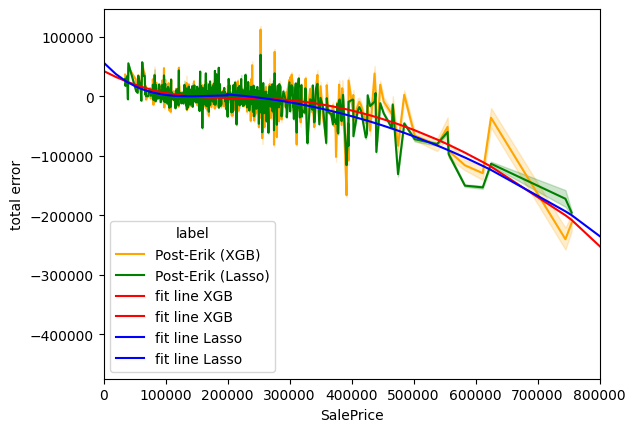

In [45]:
model_low_xgb = np.poly1d(np.polyfit(details_xgb[details_xgb["SalePrice"] < 400_000]["SalePrice"], details_xgb[details_xgb["SalePrice"] < 400_000]["total error"], 4))
model_low_lasso = np.poly1d(np.polyfit(details_lasso[details_lasso["SalePrice"] < 400_000]["SalePrice"], details_lasso[details_lasso["SalePrice"] < 400_000]["total error"], 4))
model_hi_xgb = np.poly1d(np.polyfit(details_xgb[details_xgb["SalePrice"] >= 200_000]["SalePrice"], details_xgb[details_xgb["SalePrice"] >= 200_000]["total error"], 2))
model_hi_lasso = np.poly1d(np.polyfit(details_lasso[details_lasso["SalePrice"] >= 200_000]["SalePrice"], details_lasso[details_lasso["SalePrice"] >= 200_000]["total error"], 2))

display.display(details)
print("XGB low fit polynomial coefficients:", list(model_low_xgb))
print("Lasso low fit polynomial coefficients:", list(model_low_lasso))
print("XGB high fit polynomial coefficients:", list(model_hi_xgb))
print("Lasso high fit polynomial coefficients:", list(model_hi_lasso))

sns.lineplot(details_xgb, x="SalePrice", y="total error", hue="scheme", palette=['orange'])
sns.lineplot(details_lasso, x="SalePrice", y="total error", hue="scheme", palette=['g'])

x_low = np.concatenate(([0], details[details["SalePrice"] < 200_000]["SalePrice"].unique(), [20_000]))
x_hi = np.concatenate(([200_000], details[details["SalePrice"] >= 200_000]["SalePrice"].unique(), [1_000_000]))
fit_line_low_xgb = pd.DataFrame({"SalePrice": x_low, "error": model_low_xgb(x_low), "label": "fit line XGB"})
fit_line_hi_xgb = pd.DataFrame({"SalePrice": x_hi, "error": model_hi_xgb(x_hi), "label": "fit line XGB"})
fit_line_low_lasso = pd.DataFrame({"SalePrice": x_low, "error": model_low_lasso(x_low), "label": "fit line Lasso"})
fit_line_hi_lasso = pd.DataFrame({"SalePrice": x_hi, "error": model_hi_lasso(x_hi), "label": "fit line Lasso"})
sns.lineplot(fit_line_low_xgb, x="SalePrice", y="error", palette=['r'], hue='label')
sns.lineplot(fit_line_hi_xgb, x="SalePrice", y="error", palette=['r'], hue='label')
sns.lineplot(fit_line_low_lasso, x="SalePrice", y="error", palette=['b'], hue='label')
sns.lineplot(fit_line_hi_lasso, x="SalePrice", y="error", palette=['b'], hue='label')

# x limits 0 to 800,000
plt.xlim(0, 800_000)

#TODO: consider the pros & cons of fitting based on:
#         - the absolute error 
#         - the RMSE error 
#         - the % error 

In [312]:
# x = pd.DataFrame(details.SalePrice.unique())
# x = full_data[full_data.SalePrice.notna()].SalePrice
x = details.SalePrice
x.quantile(.0042), x.quantile(.99)
# x/2
# plt.rcParams['figure.figsize'] = [6.4, 4.8]

(np.float64(52500.0), np.float64(446261.0))

# Ridge Parameter Optimizing

/tmp/ipykernel_878/1450461473.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results = pd.DataFrame({"prediction": predictions, "SalePrice": full_data[full_data["SalePrice"].notna()][full_data["Id"].isin(td["Id"].to_list())]["SalePrice"]})


<Axes: xlabel='SalePrice', ylabel='diff'>

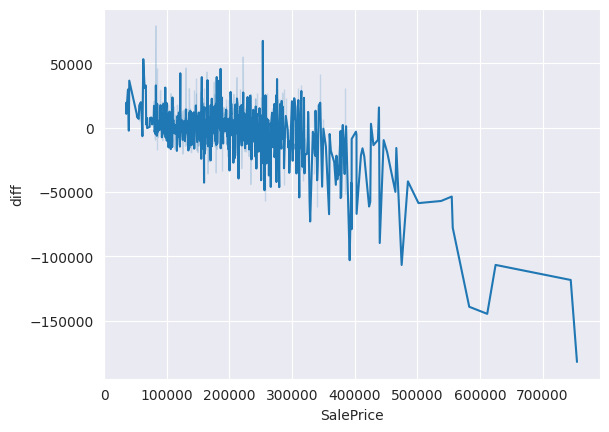

In [421]:
use_saved_training_data = True

if not use_saved_training_data:
    td = transform_data(
        data_set=full_data,
        transformations=post_erik + [
            Transformation(column_name="SalePrice", function=re_map, args=[log]),
            Transformation(function=normal_reskew, pre_fit=False, post_fit=True),
        ],
        pre_fit=True,
    )["data_set"]
    td.to_csv('mike_all.csv', index=False)
else:
    td = pd.read_csv("mike_all.csv")

from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor

def get_new_alphas(alpha, alphas, min_alpha=0.0, max_alpha=50.0):
    index = alphas.index(float(alpha))
    dif = (alpha - alphas[index - 1]) / 2
    output = sorted(set([max(alpha - dif, min_alpha), alpha, min(alpha + dif, max_alpha)]))
    return output

history = []
# for random_state in [4, 42, 420]:
for random_state in [42]:
    for splits in [9]:
    # for splits in range(5,15):
        alphas = [float(f"0.000{x}") for x in range(1, 10)]
        ratios = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
        # for _ in range(30):
        for _ in [1]:
            # pipeline = make_pipeline(RobustScaler(), RidgeCV(
            #     alphas=alphas,
            #     cv=KFold(
            #         n_splits=splits,
            #         shuffle=True,
            #         random_state=random_state,
            #     ),
            # ))
            # pipeline = make_pipeline(RobustScaler(), ElasticNetCV(
            #     max_iter=int(1e7),
            #     alphas=alphas,
            #     random_state=42,
            #     l1_ratio=ratios,
            #     cv=KFold(
            #         n_splits=splits,
            #         shuffle=True,
            #         random_state=random_state,
            # )))
            model = LGBMRegressor(
                objective='regression', 
                num_leaves=4,
                learning_rate=0.01, 
                n_estimators=5000,
                max_bin=200, 
                bagging_fraction=0.75,
                bagging_freq=5, 
                bagging_seed=7,
                feature_fraction=0.2,
                feature_fraction_seed=7,
                verbose=-1,
                min_data_in_leaf=2,
                min_sum_hessian_in_leaf=11
            )
            model = pipeline.fit(td[td["SalePrice"].notna()].drop(["SalePrice", "Id"], axis=1), td[td["SalePrice"].notna()]["SalePrice"])
            model.fit(td[td["SalePrice"].notna()].drop(["SalePrice", "Id"], axis=1), td[td["SalePrice"].notna()]["SalePrice"])
            predictions = exp(model.predict(td[td["SalePrice"].notna()].drop(["SalePrice", "Id"], axis=1)))
            # alpha = model[1].alpha_
            # alphas = get_new_alphas(model[1].alpha_, alphas, max_alpha=1.0)
            # ratio = model[1].l1_ratio_
            # ratios = get_new_alphas(model[1].l1_ratio_, ratios, max_alpha=1.0)
        # history.append({"α": alpha, "l1 ratio": ratio, "splits": splits, "random state": random_state})
        # print("       α =", round(alpha, u=alphas[1] - alphas[0], format="Drake"))
        # print("l1_ratio =", round(ratio, u=ratios[1] - ratios[0], format="Drake"))
# results = pd.DataFrame({"α": alpha, "prediction": predictions, "SalePrice": full_data[full_data["SalePrice"].notna()][full_data["Id"].isin(td["Id"].to_list())]["SalePrice"]})
results = pd.DataFrame({"prediction": predictions, "SalePrice": full_data[full_data["SalePrice"].notna()][full_data["Id"].isin(td["Id"].to_list())]["SalePrice"]})
results["diff"] = results.apply(lambda x: x["prediction"] - x["SalePrice"], axis=1)

sns.set_style("darkgrid")
sns.lineplot(results, x="SalePrice", y="diff")
# sns.lineplot(pd.DataFrame(history), x="splits", y="α")

In [420]:
param = {'C' : [15, 17, 19, 21], 'epsilon': [0.007, 0.008, 0.009], 'gamma' : [0.0002, 0.0003, 0.0004, 0.0005, 0.0006]}
param = {'C' : [14, 15, 16], 'epsilon': [0.009, .01, .011], 'gamma' : [float(f"0.000{x}") for x in range(6, 9)]}
param = {'C' : [int(x) for x in range(7,9+1)], 'epsilon': [float(f"0.01{x}") for x in range(4, 7+1)], 'gamma' : [float(f"0.000{x}") for x in range(7, 9+1)]}
param = {'C' : [7, 11, 15], 'epsilon': [.017, .01, .007], 'gamma' : [.0009, .0008, .0004]}

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
grids = GridSearchCV(svr, param, cv=KFold(
    n_splits=10,
    shuffle=True,
    random_state=42,
))

grids.fit(td[td["SalePrice"].notna()].drop(["SalePrice", "Id"], axis=1), td[td["SalePrice"].notna()]["SalePrice"])

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [7, 11, 15], 'epsilon': [0.017, 0.01, 0.007],
                         'gamma': [0.0009, 0.0008, 0.0004]})

In [409]:
grids

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [15, 20, 23], 'coef0': [0.01, 10, 0.5],
                         'degree': [3, 8], 'gamma': [0.0002, 0.0003, 0.0004]})